# Setup

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sns.set(rc={'figure.figsize': (11.7, 8.27), # landscape A4
    'figure.dpi': 300.00,
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    },
    context='poster'
)

In [3]:
palette = sns.color_palette('deep')
palette = palette[0:3] + [palette[4]] + palette[6:]
palette = sns.color_palette(palette, n_colors=8)
palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [4]:
def preprocess_df(df):
    df = df.iloc[2:]
    df = df.apply(pd.to_numeric)
    df = df.reset_index(drop=True)
    return df

In [5]:
def create_plotting_df(df, col_list):
    new_df = pd.DataFrame()

    for col_name in col_list:
        means = np.array(df[col_name])
        sigmas = np.array(df[str(col_name + ".1")])

        lower_bound = means - sigmas
        upper_bound = means + sigmas

        new_df[col_name] = means
        new_df[str(col_name + "_std")] = sigmas
        new_df[str(col_name + "_lower")] = lower_bound
        new_df[str(col_name + "_upper")] = upper_bound

    return new_df


def create_mean_df(df, col_list, mean_col):
    new_df = pd.DataFrame()
    means = []
    sigmas = []

    for col_name in col_list:
        means.append(np.array(df[col_name]))
        sigmas.append(np.array(df[str(col_name + ".1")]))

    means = np.mean(means, axis=0)
    sigmas = np.mean(sigmas, axis=0)

    lower_bound = means - sigmas
    upper_bound = means + sigmas

    new_df[mean_col] = means
    new_df[str(mean_col + "_std")] = sigmas
    new_df[str(mean_col + "_lower")] = lower_bound
    new_df[str(mean_col + "_upper")] = upper_bound

    return new_df


def plot_df(df, col_list, label_list, ax=None, mean=None, color=None):
    if mean is None:
        plotting_df = create_plotting_df(df, col_list)

        for idx, col_name in enumerate(col_list):
            ax = sns.lineplot(data=plotting_df, x=plotting_df.index,
                            y=plotting_df[col_name], ax=ax, label=label_list[idx], color=color)
            plt.fill_between(plotting_df.index, plotting_df[str(
                col_name + "_lower")], plotting_df[str(col_name + "_upper")], alpha=.2, color=ax.get_lines()[-1].get_color())
    if isinstance(mean, str):
        plotting_df = create_mean_df(df, col_list, mean)
        ax = sns.lineplot(data=plotting_df, x=plotting_df.index,
                        y=plotting_df[mean], ax=ax, label=mean, color=color)
        plt.fill_between(plotting_df.index, plotting_df[str(
            mean + "_lower")], plotting_df[str(mean + "_upper")], alpha=.2, color=ax.get_lines()[-1].get_color())

    return ax

# Benchmark Results

## Pre-process Dataframes

In [6]:
# Loss summands
old_ce_df = preprocess_df(pd.read_csv("../Experiments/calibration2/ce.csv"))
ce_df = preprocess_df(pd.read_csv("../Experiments/replicate1/vanilla_teacher18/vanilla.csv"))
kld_df = preprocess_df(pd.read_csv("../Experiments/replicate1/KLD_only/kld.csv"))

# First benchmark
# vanilla_df = preprocess_df(pd.read_csv("../Experiments/session3/vanilla.csv"))
vanilla_df1 = preprocess_df(pd.read_csv("../Experiments/calibration1/vanilla.csv"))
dml_df1 = preprocess_df(pd.read_csv("../Experiments/calibration1/dml.csv"))
dmle_df1 = preprocess_df(pd.read_csv("../Experiments/calibration1/dml_e.csv"))
tfkd_df1 = preprocess_df(pd.read_csv("../Experiments/calibration1/tfkd.csv"))
base_df = preprocess_df(pd.read_csv("../Experiments/calibration3/vanilla.csv"))
benchmark1 = [vanilla_df1, tfkd_df1, dml_df1, dmle_df1]

# Final hyperparameters
vanilla_df2 = preprocess_df(pd.read_csv("../Experiments/final_hyperparams/vanilla.csv"))
dml_df2 = preprocess_df(pd.read_csv("../Experiments/final_hyperparams/dml.csv"))
dmle_df2 = preprocess_df(pd.read_csv("../Experiments/final_hyperparams/dml_e.csv"))
tfkd_df2 = preprocess_df(pd.read_csv("../Experiments/final_hyperparams/tfkd.csv"))
benchmark2 = [vanilla_df2, tfkd_df2, dml_df2, dmle_df2]

In [7]:
# Labels
keep_vanilla = ["Accuracy/Validation teacher", "Accuracy/Validation student"]
labels_vanilla = ["KD Teacher", "KD Student"]

keep_dml = [] # ["Accuracy/Validation student0", "Accuracy/Validation student1", "Accuracy/Validation student2"]
labels_dml = [] # ["Student 1", "Student 2", "Student 3"]
for i in range(3):
    keep_dml.append("Accuracy/Validation student{}".format(i))
    labels_dml.append("Student {}".format(i+1))
best_dml = ["Accuracy/Best student"]

loss_student = ["Loss/Cross-entropy student", "Loss/Divergence student",
                "Loss/Entropy student", "Loss/Calibration student"] # "Loss/Calibration teacher"
loss_dml = ["Loss/Cross-entropy student0", "Loss/Divergence student0", "Loss/Entropy student0", "Loss/Calibration student0",
            "Loss/Cross-entropy student1", "Loss/Divergence student1", "Loss/Entropy student1", "Loss/Calibration student1",
            "Loss/Cross-entropy student2", "Loss/Divergence student2", "Loss/Entropy student2", "Loss/Calibration student2"]

loss_labels = ["Cross-entropy", "Divergence",
               "Entropy", "Calibration"] # "Calibration Teacher"
loss_labels_dml = ["Cross-entropy 1", "Divergence 1", "Entropy 1", "Calibration 1",
                   "Cross-entropy 2", "Divergence 2", "Entropy 2", "Calibration 2",
                   "Cross-entropy 3", "Divergence 3", "Entropy 3", "Calibration 3"]
loss_dml_ce = ["Loss/Cross-entropy student0", "Loss/Cross-entropy student1", "Loss/Cross-entropy student2"]
loss_dml_kld = ["Loss/Divergence student0", "Loss/Divergence student2", "Loss/Divergence student2"]
loss_dml_ent = ["Loss/Entropy student0", "Loss/Entropy student1", "Loss/Entropy student2"]
loss_dml_cal = ["Loss/Calibration student0", "Loss/Calibration student1", "Loss/Calibration student2"]


## Benchmark Plots

In [11]:
bench = benchmark2
bench_name = "benchmark2"

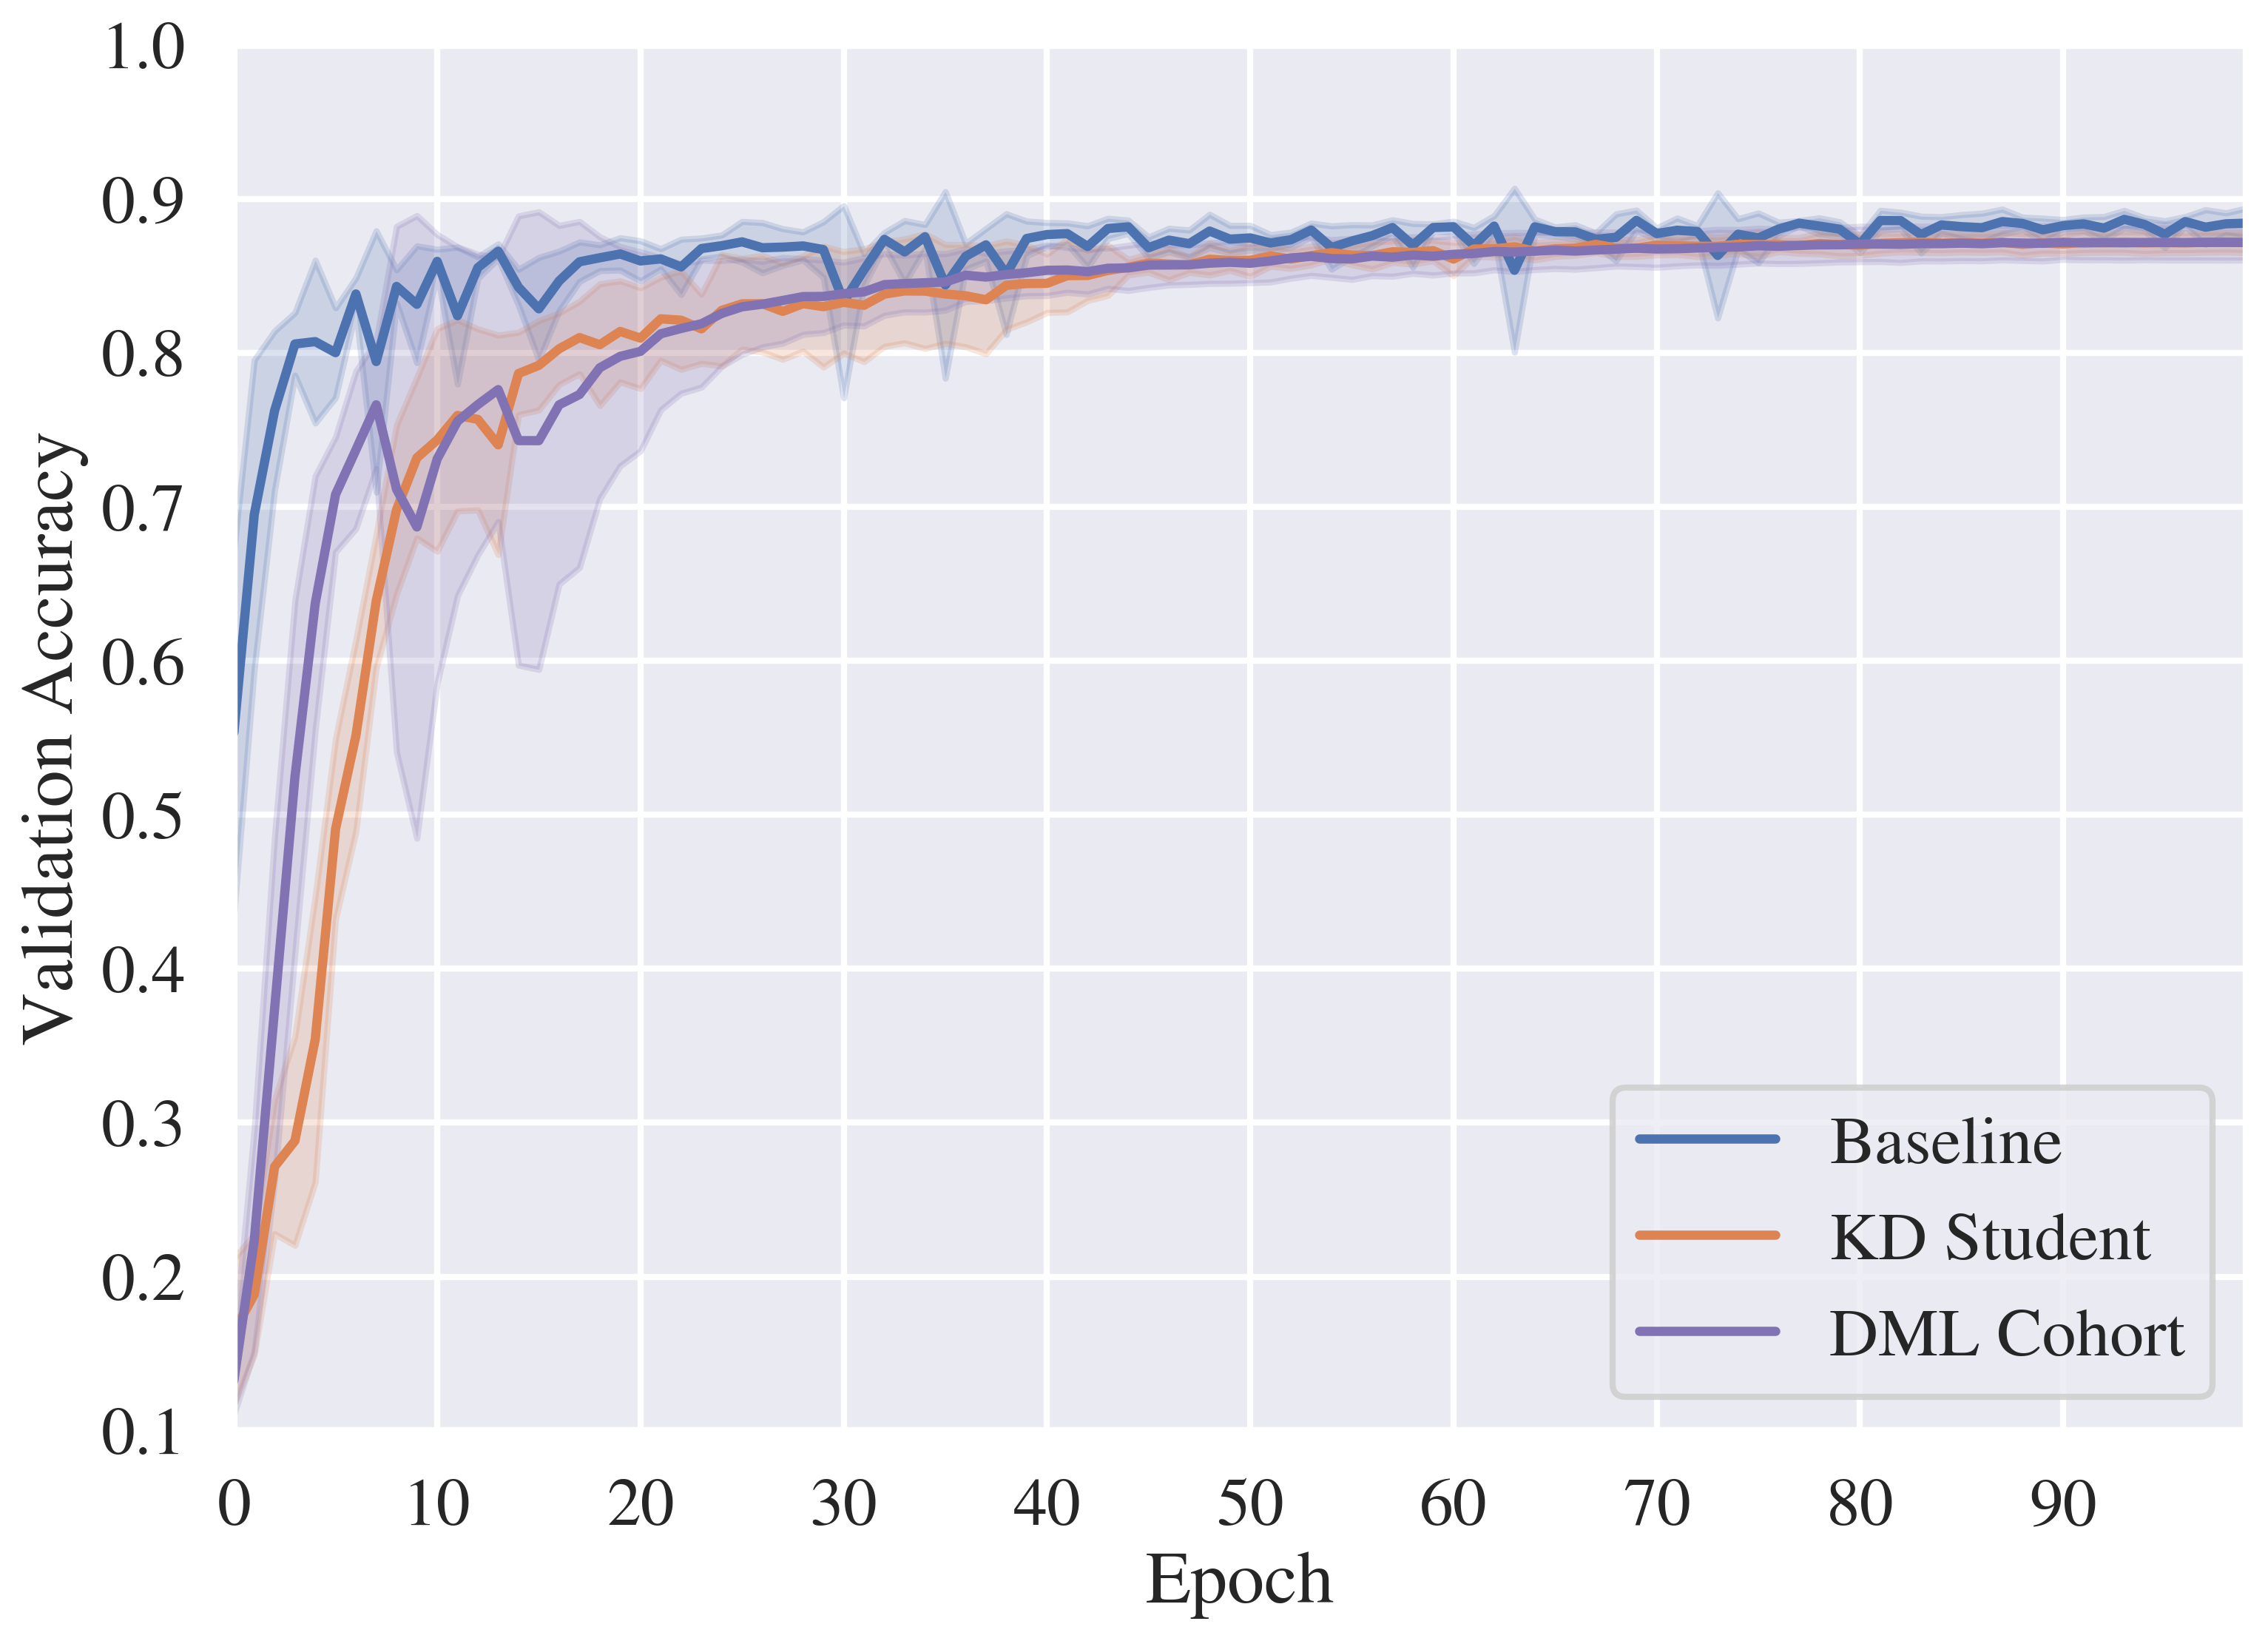

In [12]:
ax = plot_df(base_df, [keep_vanilla[0]], ["Baseline"], color=palette[0])
ax = plot_df(bench[0], keep_vanilla[1:], labels_vanilla[1:], ax=ax, color=palette[1])
ax = plot_df(bench[1], [keep_vanilla[1]], ["Tf-KD Student"], ax=ax, color=palette[2])
ax = plot_df(bench[2], keep_dml, labels_dml, ax=ax, mean="DML Cohort", color=palette[3])
# ax = plot_df(benchmark1[2], [keep_dml[-1]], ["DML Best"], color=palette[4])
# ax = plot_df(benchmark2[2], best_dml, ["DML Best"], color=palette[4])
# ax = plot_df(benchmark2[1], [keep_vanilla[1]], ["Tf-KD Student w/o smoothing"], ax=ax)

ax.set(xlabel='Epoch', ylabel='Validation Accuracy')
ax.set_ylim(0.1, 1)
ax.set_xlim(0, 99)
ax.set_xticks([i for i in range(0, 100, 10)])
if bench_name == "benchmark2":
    ax.legend(title='', loc='lower right')  # bbox_to_anchor=[1.2,1.0]
else:
    ax.get_legend().remove()

plt.savefig(f"/home/pia/Pictures/Plots/Thesis/{bench_name}_acc.pdf", bbox_inches="tight")
plt.savefig(f"/home/pia/Pictures/Plots/Thesis/{bench_name}_acc.png", bbox_inches="tight")

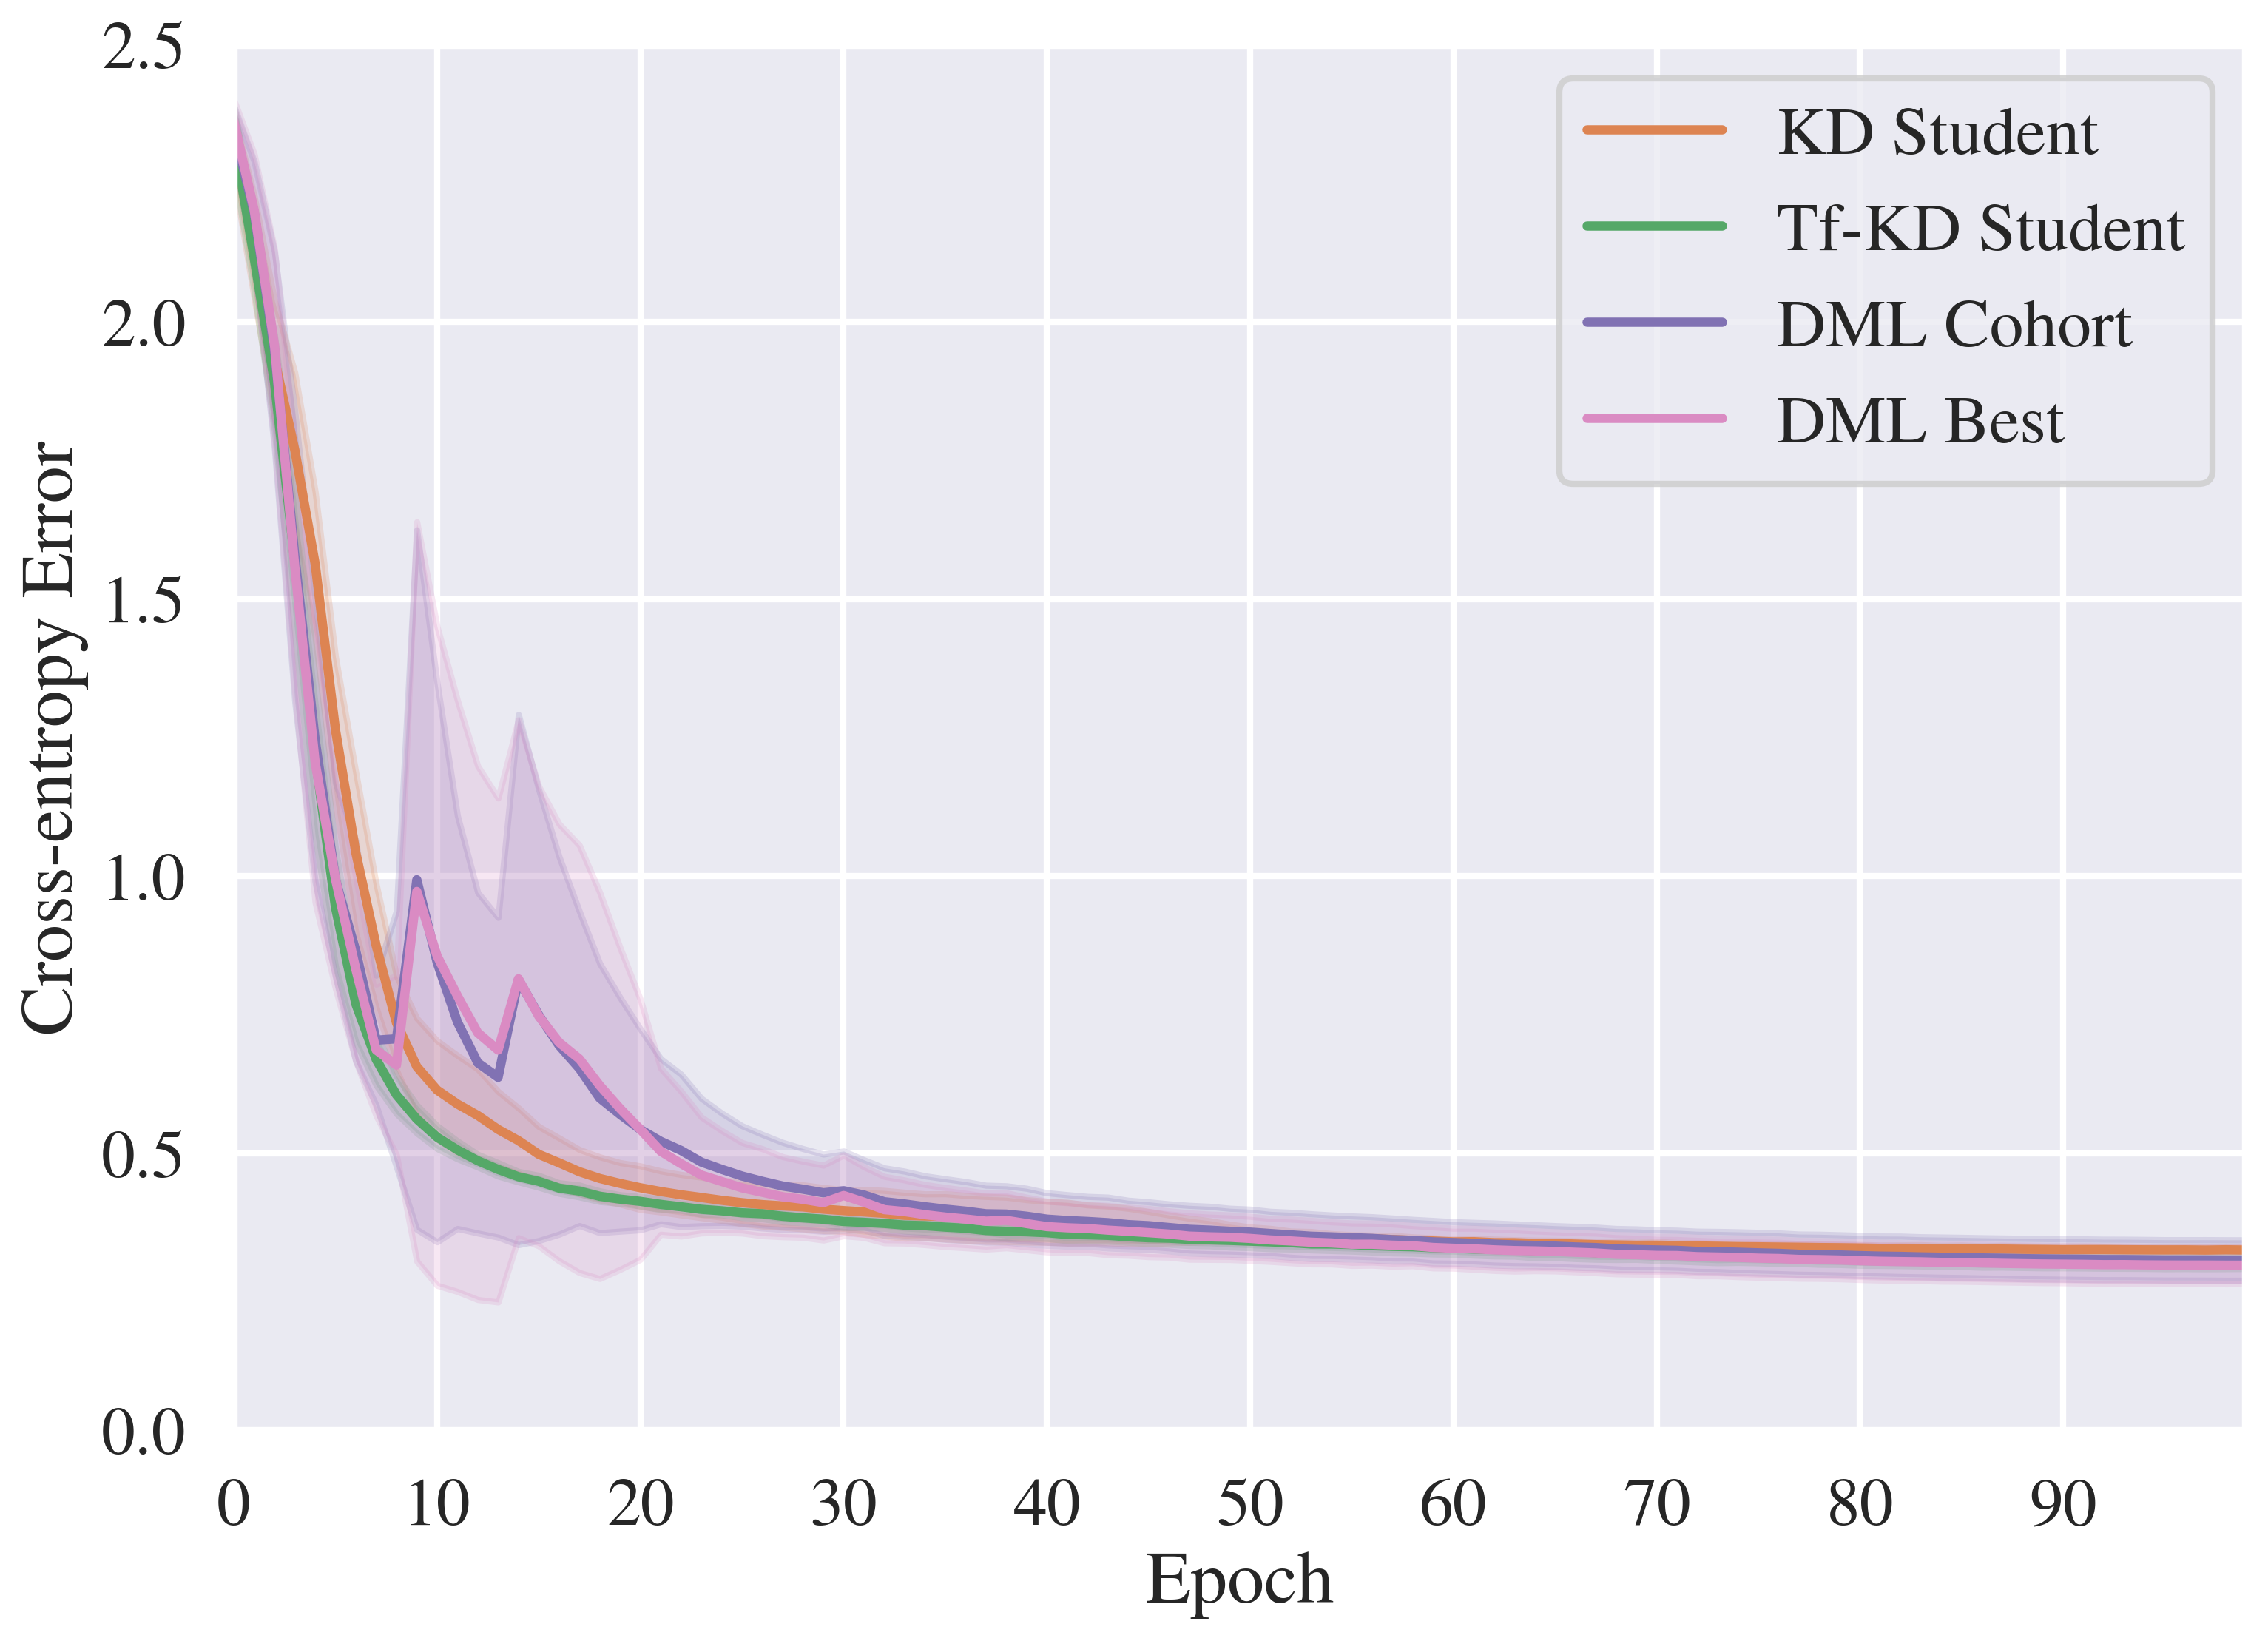

In [69]:
ax = plot_df(bench[0], [loss_student[0]], ["KD Student"], color=palette[1])
ax = plot_df(bench[1], [loss_student[0]], ["Tf-KD Student"], ax=ax, color=palette[2])
# ax = plot_df(benchmark1[0], [loss_student[0]], ["Original Tf-KD"], ax=ax, color=palette[-1])
ax = plot_df(bench[2], loss_dml_ce, loss_labels_dml, ax=ax, mean="DML Cohort", color=palette[3])
ax = plot_df(bench[2], [loss_dml_ce[0]], ["DML Best"], ax=ax, color=palette[4])

ax.set(xlabel='Epoch', ylabel='Cross-entropy Error')
ax.set_ylim(0.0, 2.5)
ax.set_xlim(0, 99)
ax.set_xticks([i for i in range(0, 100, 10)])
if bench_name == "benchmark2":
    ax.legend(title='', loc='upper right')  # bbox_to_anchor=[1.2,1.0]
else:
    ax.get_legend().remove()

plt.savefig(f"/home/pia/Pictures/Plots/Thesis/{bench_name}_ce.pdf", bbox_inches="tight")
plt.savefig(f"/home/pia/Pictures/Plots/Thesis/{bench_name}_ce.png", bbox_inches="tight")

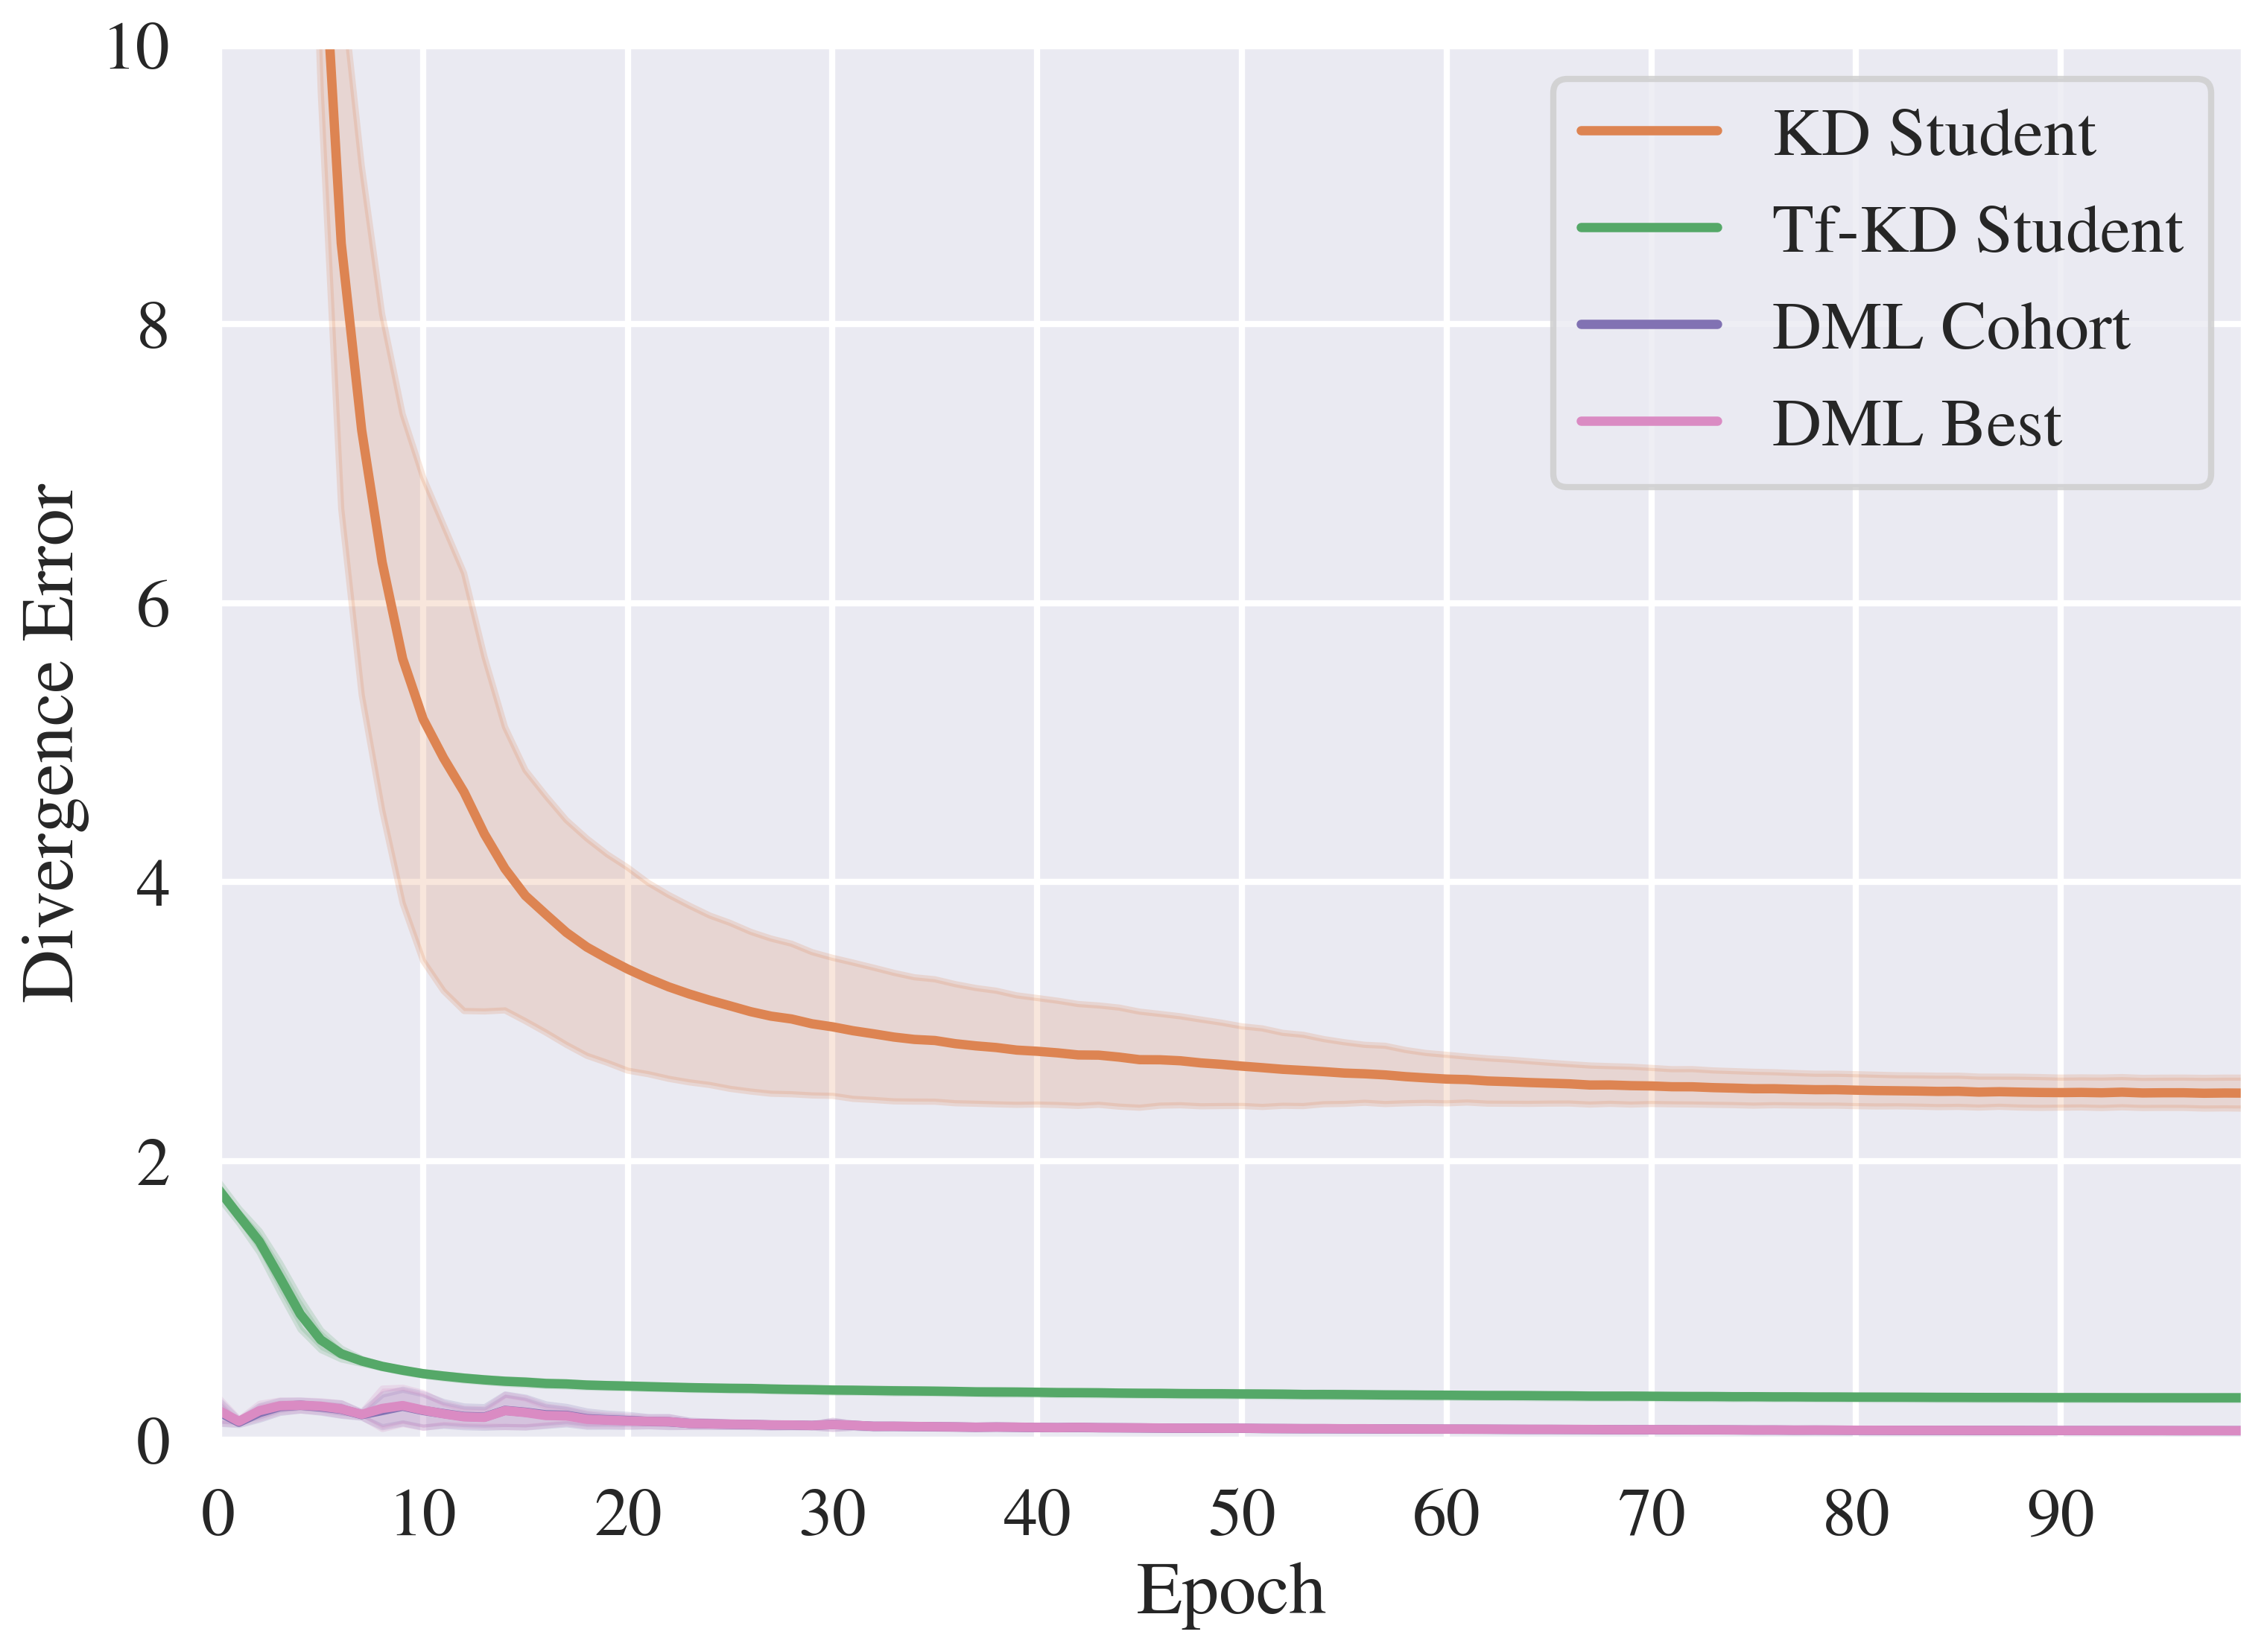

In [71]:
ax = plot_df(bench[0], [loss_student[1]], ["KD Student"], color=palette[1])
ax = plot_df(bench[1], [loss_student[1]], ["Tf-KD Student"], ax=ax, color=palette[2])
# ax = plot_df(benchmark1[1], [loss_student[1]], ["Original Tf-KD"], ax=ax, color=palette[-1])
ax = plot_df(bench[2], loss_dml_kld, loss_labels_dml, ax=ax, mean="DML Cohort", color=palette[3])
ax = plot_df(bench[2], [loss_dml_kld[-1]], ["DML Best"], ax=ax, color=palette[4])

ax.set(xlabel='Epoch', ylabel='Divergence Error')
ax.set_ylim(0.0, 10)
ax.set_xlim(0, 99)
ax.set_xticks([i for i in range(0, 100, 10)])
#ax.set_yticks([i+1 for i in range(0, 10)])
if bench_name == "benchmark2":
    ax.legend(title='', loc='upper right')  # bbox_to_anchor=[1.2,1.0]
else:
    ax.get_legend().remove()

plt.savefig(f"/home/pia/Pictures/Plots/Thesis/{bench_name}_div.pdf", bbox_inches="tight")
plt.savefig(f"/home/pia/Pictures/Plots/Thesis/{bench_name}_div.png", bbox_inches="tight")

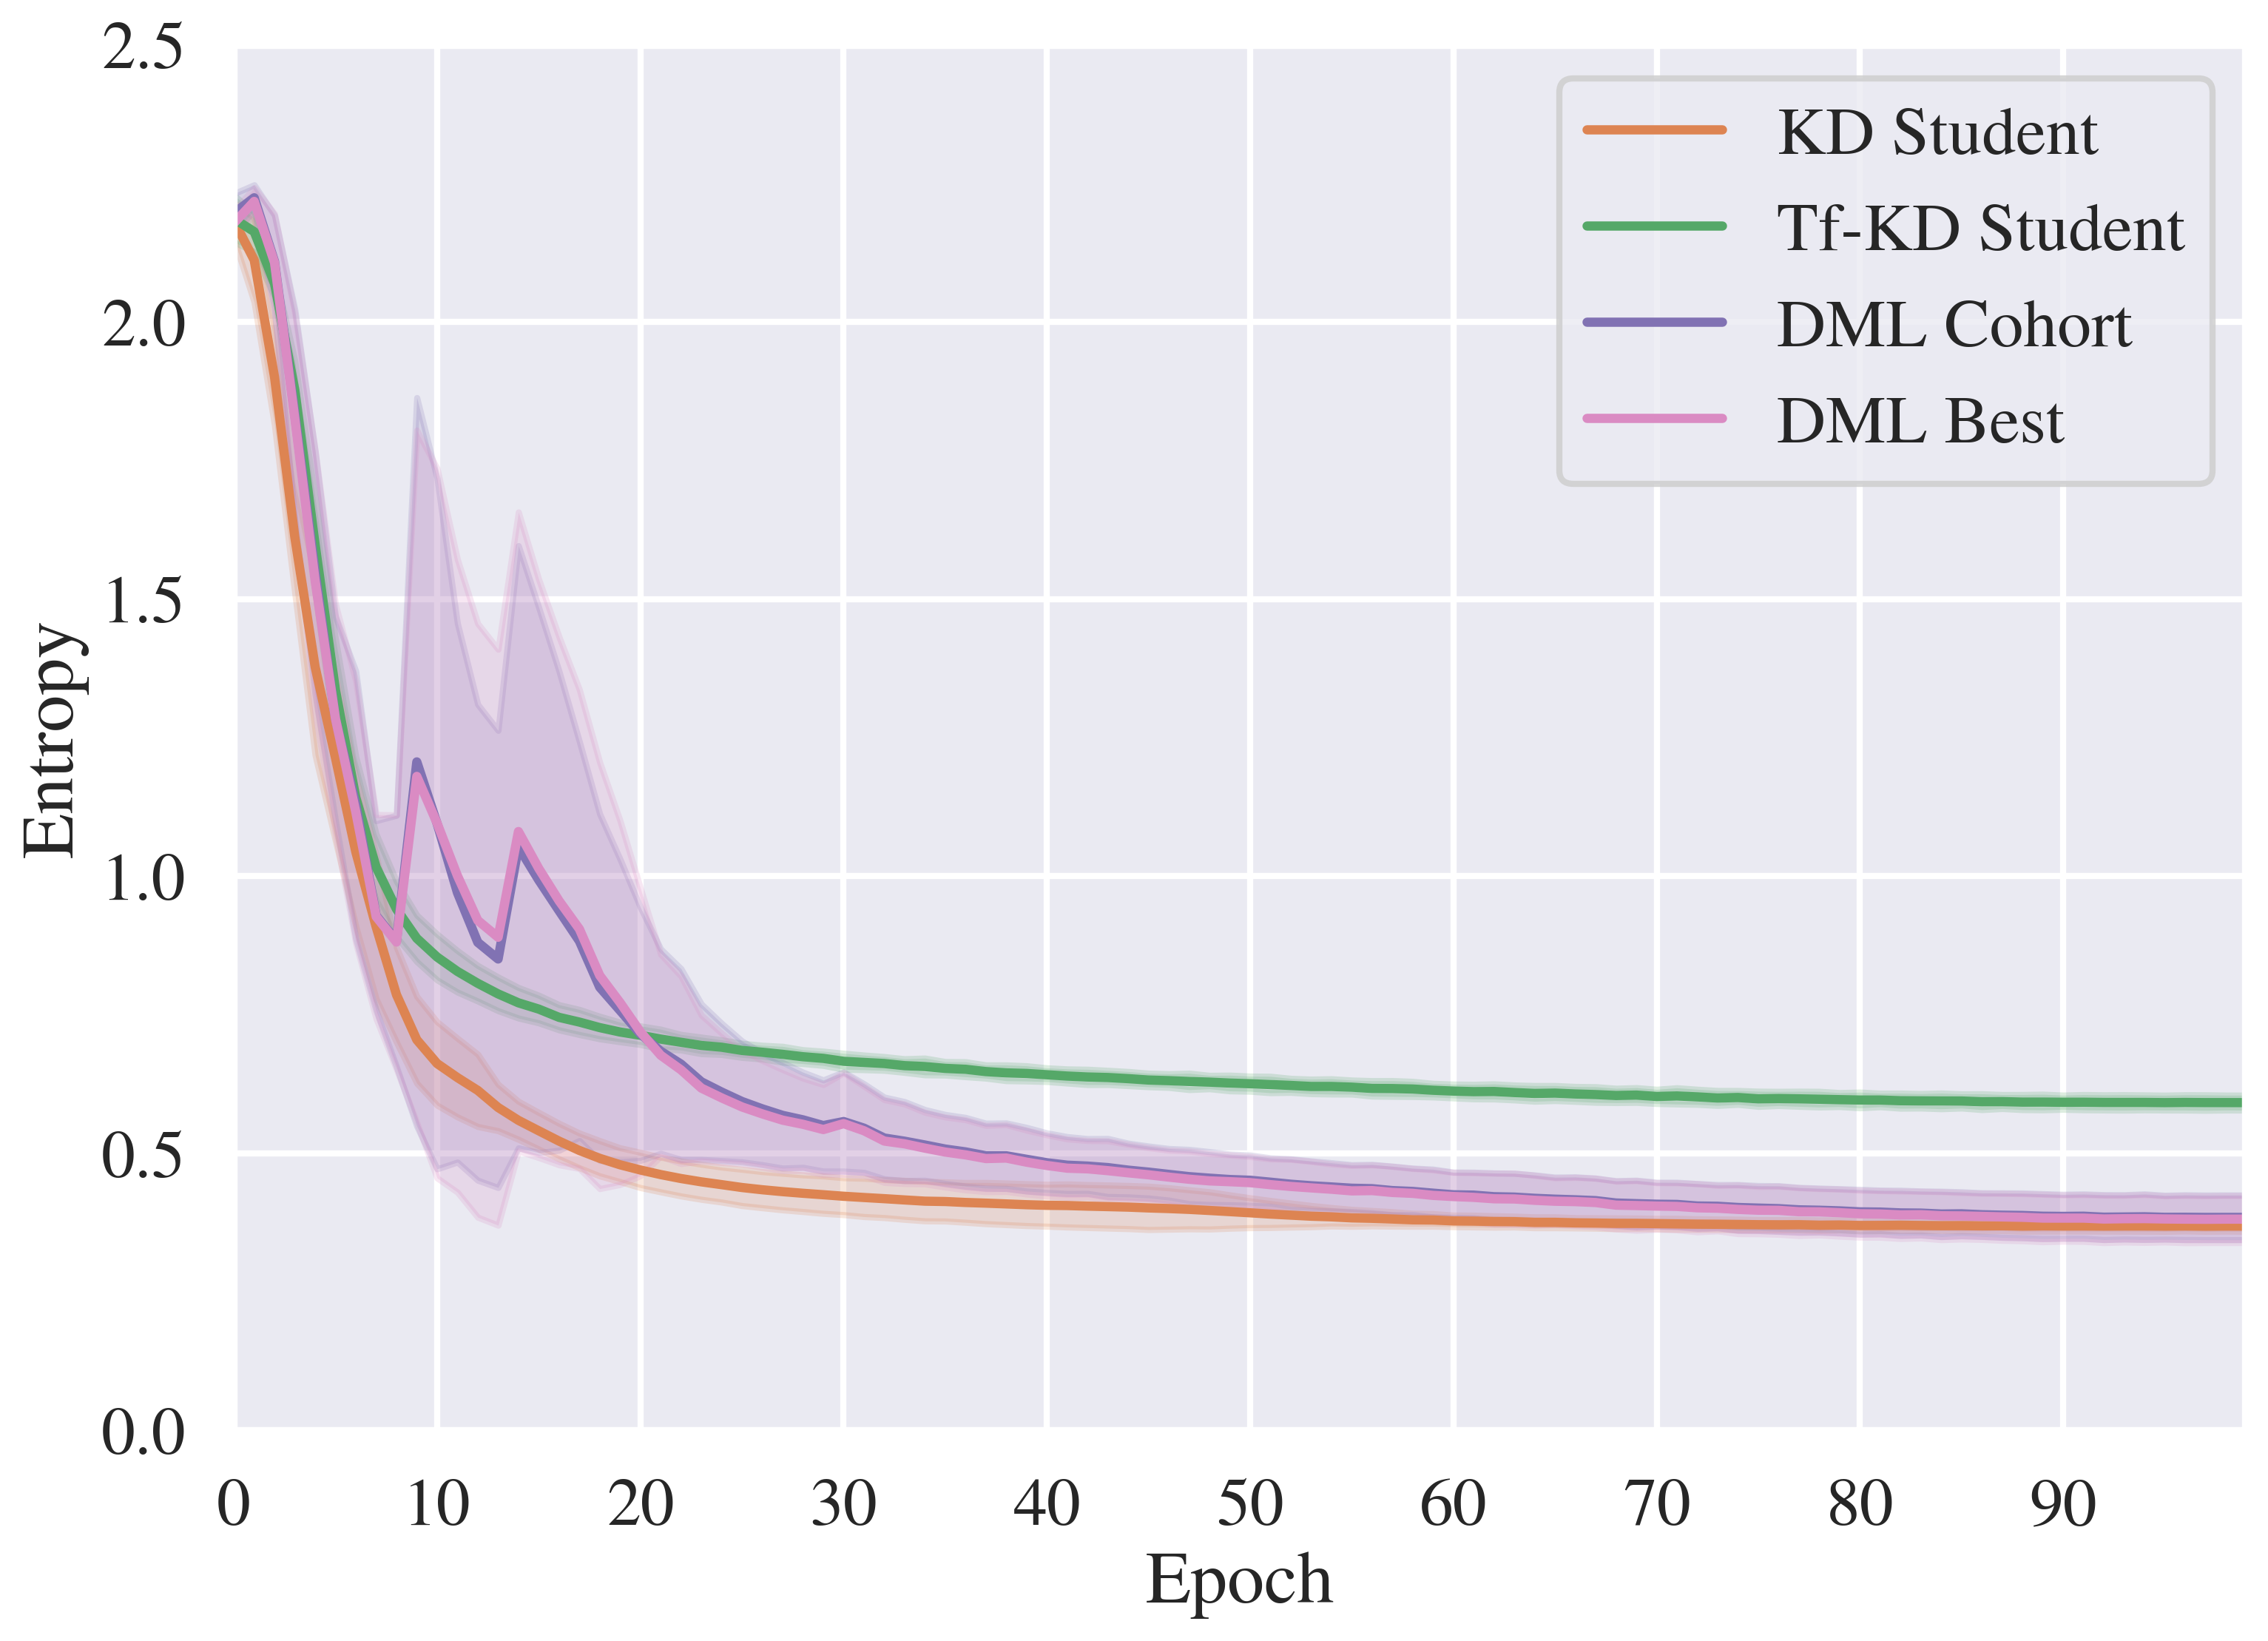

In [72]:
ax = plot_df(bench[0], [loss_student[2]], ["KD Student"], color=palette[1])
ax = plot_df(bench[1], [loss_student[2]], ["Tf-KD Student"], ax=ax, color=palette[2])
# ax = plot_df(benchmark1[1], [loss_student[2]], ["Original Tf-KD"], ax=ax, color=palette[-1])
ax = plot_df(bench[2], loss_dml_ent, loss_labels_dml, ax=ax, mean="DML Cohort", color=palette[3])
ax = plot_df(bench[2], [loss_dml_ent[0]], ["DML Best"], ax=ax, color=palette[4])

ax.set(xlabel='Epoch', ylabel='Entropy')
ax.set_ylim(0.0, 2.5)
ax.set_xlim(0, 99)
ax.set_xticks([i for i in range(0, 100, 10)])
if bench_name == "benchmark2":
    ax.legend(title='', loc='upper right')  # bbox_to_anchor=[1.2,1.0]
else:
    ax.get_legend().remove()

plt.savefig(f"/home/pia/Pictures/Plots/Thesis/{bench_name}_ent.pdf", bbox_inches="tight")
plt.savefig(f"/home/pia/Pictures/Plots/Thesis/{bench_name}_ent.png", bbox_inches="tight")

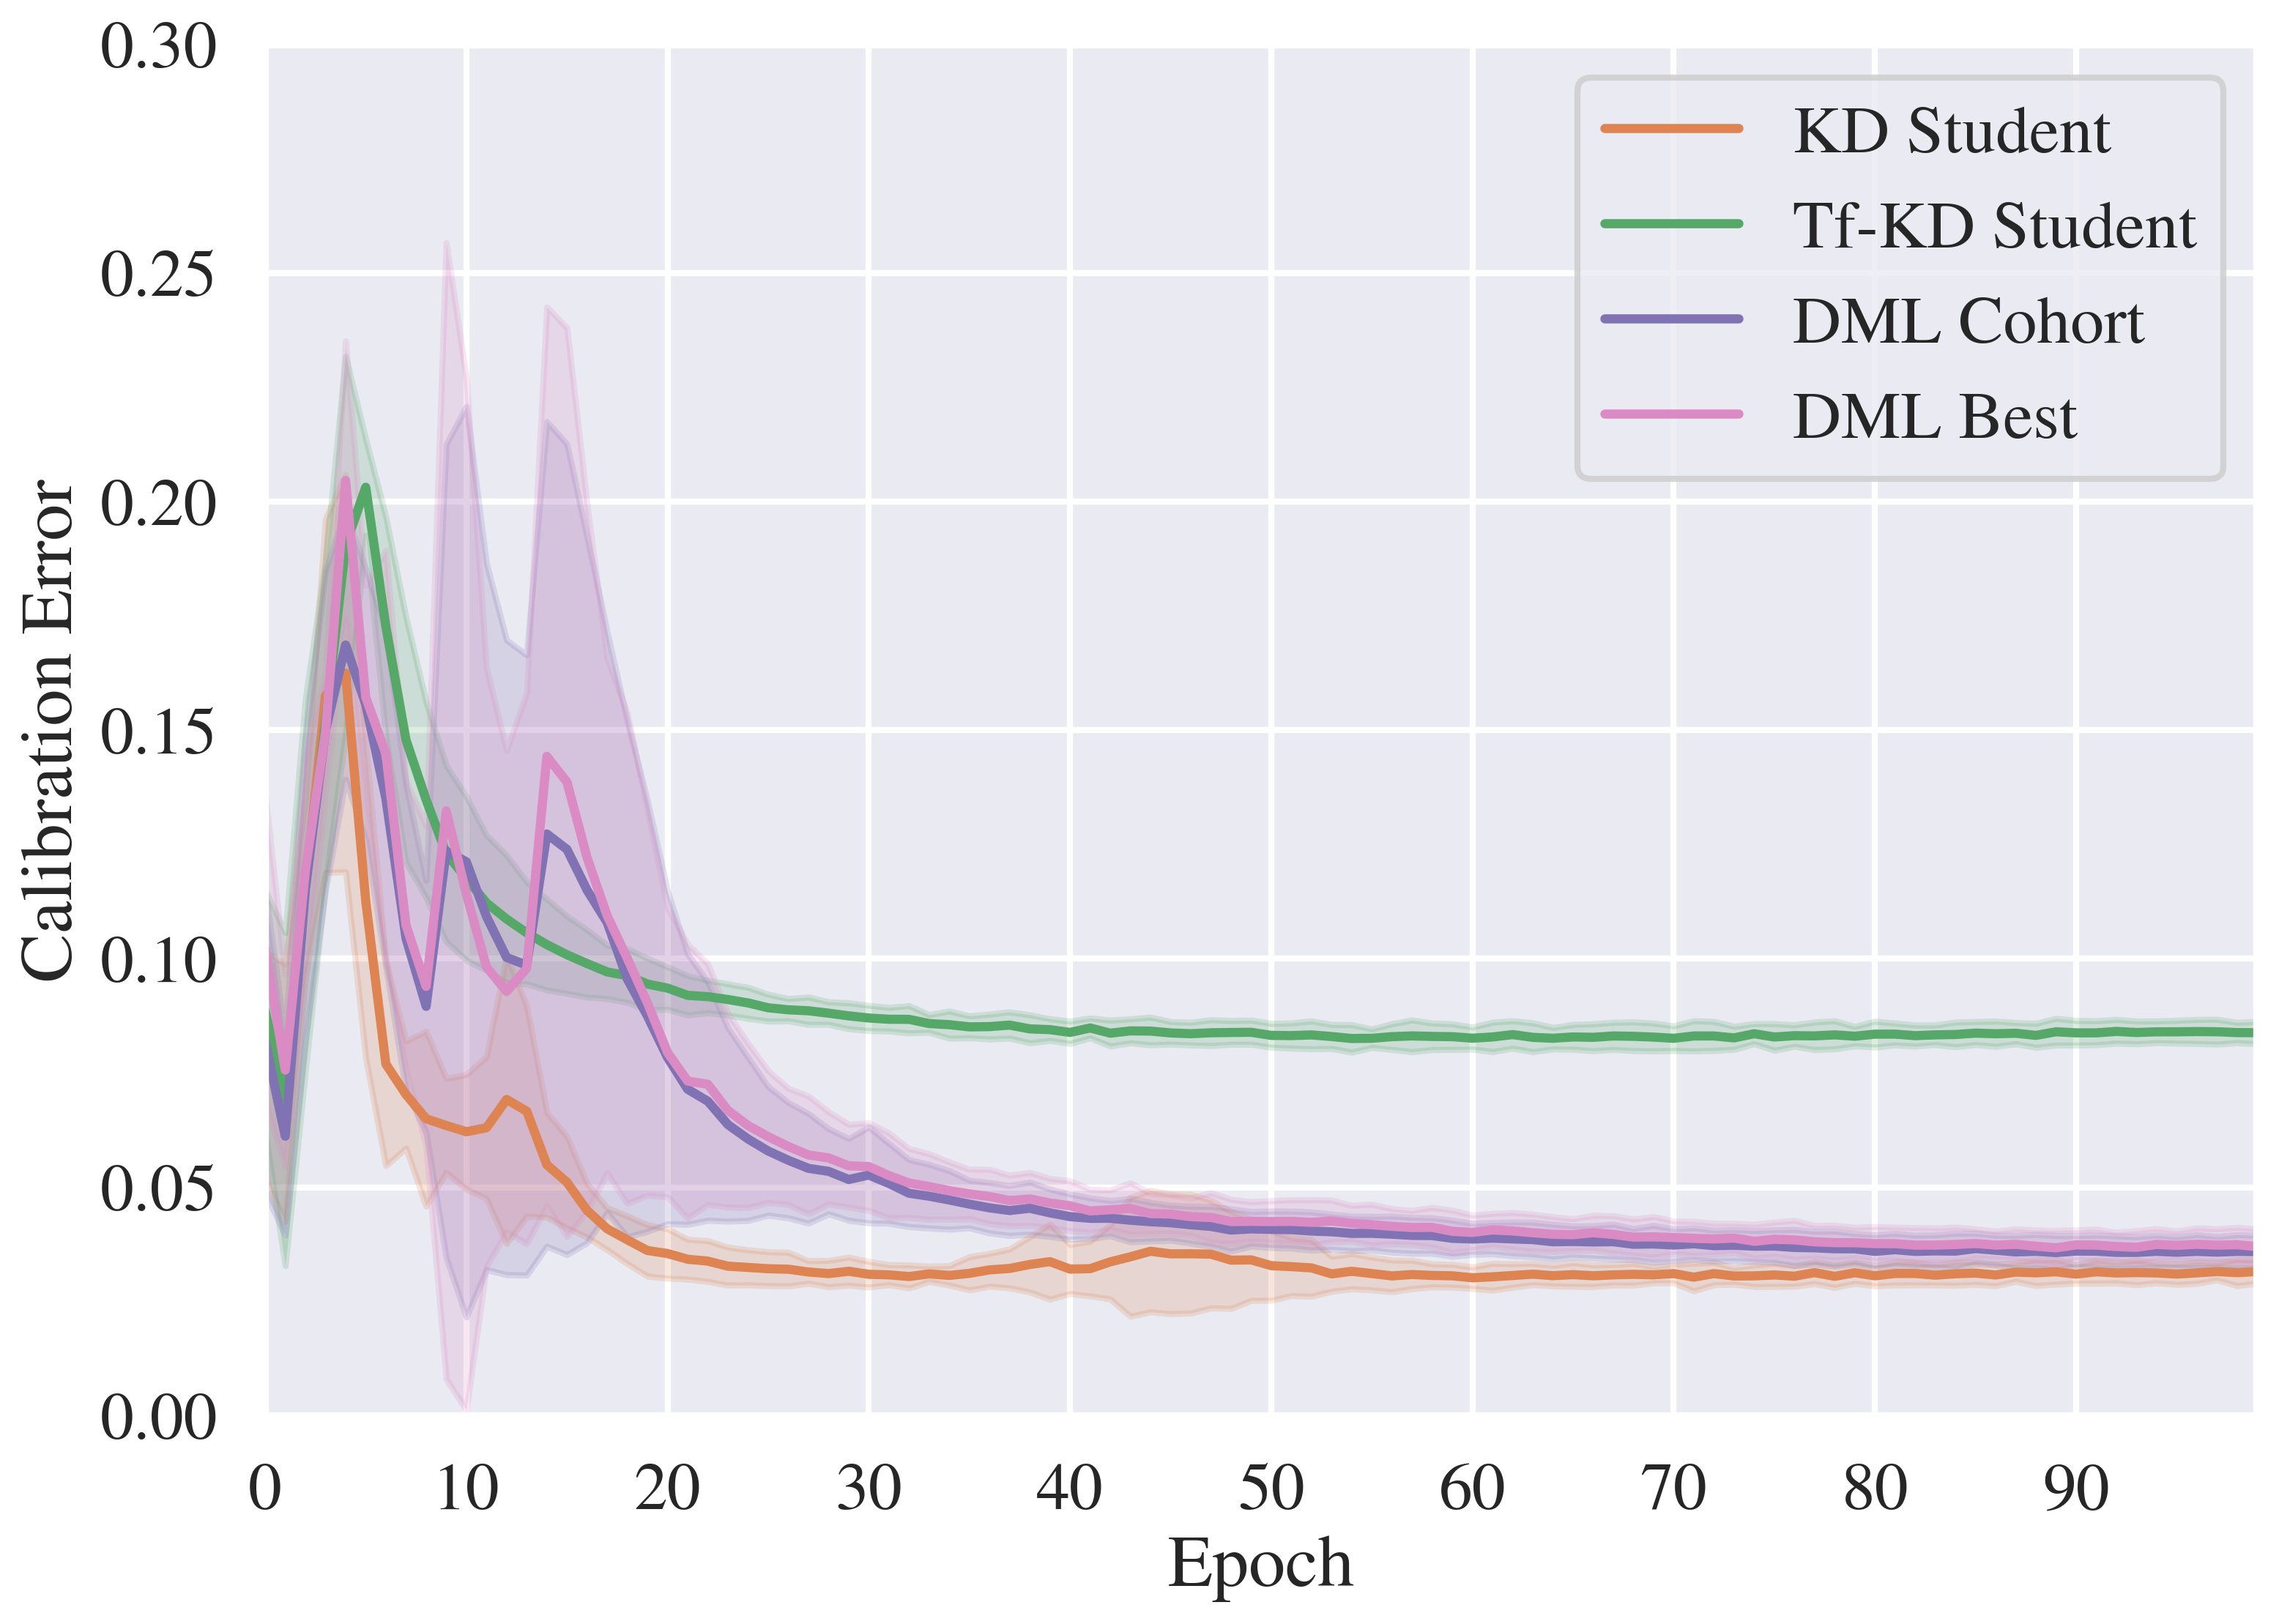

In [74]:
ax = plot_df(bench[0], [loss_student[3]], ["KD Student"], color=palette[1])
ax = plot_df(bench[1], [loss_student[3]], ["Tf-KD Student"], ax=ax, color=palette[2])
# ax = plot_df(benchmark1[1], [loss_student[3]], ["Original Tf-KD"], ax=ax, color=palette[-1])
ax = plot_df(bench[2], loss_dml_cal, loss_labels_dml, ax=ax, mean="DML Cohort", color=palette[3])
ax = plot_df(bench[2], [loss_dml_cal[0]], ["DML Best"], ax=ax, color=palette[4])

ax.set(xlabel='Epoch', ylabel='Calibration Error')
ax.set_ylim(0.0, 0.3)
ax.set_xlim(0, 99)
ax.set_xticks([i for i in range(0, 100, 10)])
if bench_name == "benchmark2":
    ax.legend(title='', loc='upper right')  # bbox_to_anchor=[1.2,1.0]
else:
    ax.get_legend().remove()

plt.savefig(f"/home/pia/Pictures/Plots/Thesis/{bench_name}_cal.pdf", bbox_inches="tight")
plt.savefig(f"/home/pia/Pictures/Plots/Thesis/{bench_name}_cal.png", bbox_inches="tight")

## DML Variants

In [6]:
def plot_df_no_color(df, col_list, label_list, ax=None, mean=None):
    if mean is None:
        plotting_df = create_plotting_df(df, col_list)

        for idx, col_name in enumerate(col_list):
            ax = sns.lineplot(data=plotting_df, x=plotting_df.index,
                            y=plotting_df[col_name], ax=ax, label=label_list[idx])
            plt.fill_between(plotting_df.index, plotting_df[str(
                col_name + "_lower")], plotting_df[str(col_name + "_upper")], alpha=.2, color=ax.get_lines()[-1].get_color())
    if isinstance(mean, str):
        plotting_df = create_mean_df(df, col_list, mean)
        ax = sns.lineplot(data=plotting_df, x=plotting_df.index,
                        y=plotting_df[mean], ax=ax, label=mean)
        plt.fill_between(plotting_df.index, plotting_df[str(
            mean + "_lower")], plotting_df[str(mean + "_upper")], alpha=.2, color=ax.get_lines()[-1].get_color())

    return ax

In [8]:
dml_palette = sns.light_palette("tab:purple", reverse=True)
dml_palette

[(0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.653289041199532, 0.5116641639899728, 0.7824986487719783),
 (0.7261859255363189, 0.6194067593524948, 0.8238208269557212),
 (0.7990828098731056, 0.7271493547150166, 0.8651430051394642),
 (0.8719796942098925, 0.8348919500775386, 0.9064651833232072),
 (0.9448765785466794, 0.9426345454400604, 0.9477873615069502)]

In [14]:
# DML modifications
session_name = "adamw-005-10-False-soft"
dml_df = pd.read_csv(f"../Experiments/hyperparams/{session_name}/dml.csv")
dml_df = preprocess_df(dml_df)

keep_dml = [] # ["Accuracy/Validation student0", "Accuracy/Validation student1", "Accuracy/Validation student2"]
labels_dml = [] # ["Student 1", "Student 2", "Student 3"]
for i in range(3):
    keep_dml.append("Accuracy/Validation student{}".format(i))
    labels_dml.append("Student {}".format(i+1))
best_dml = ["Accuracy/Best student"]

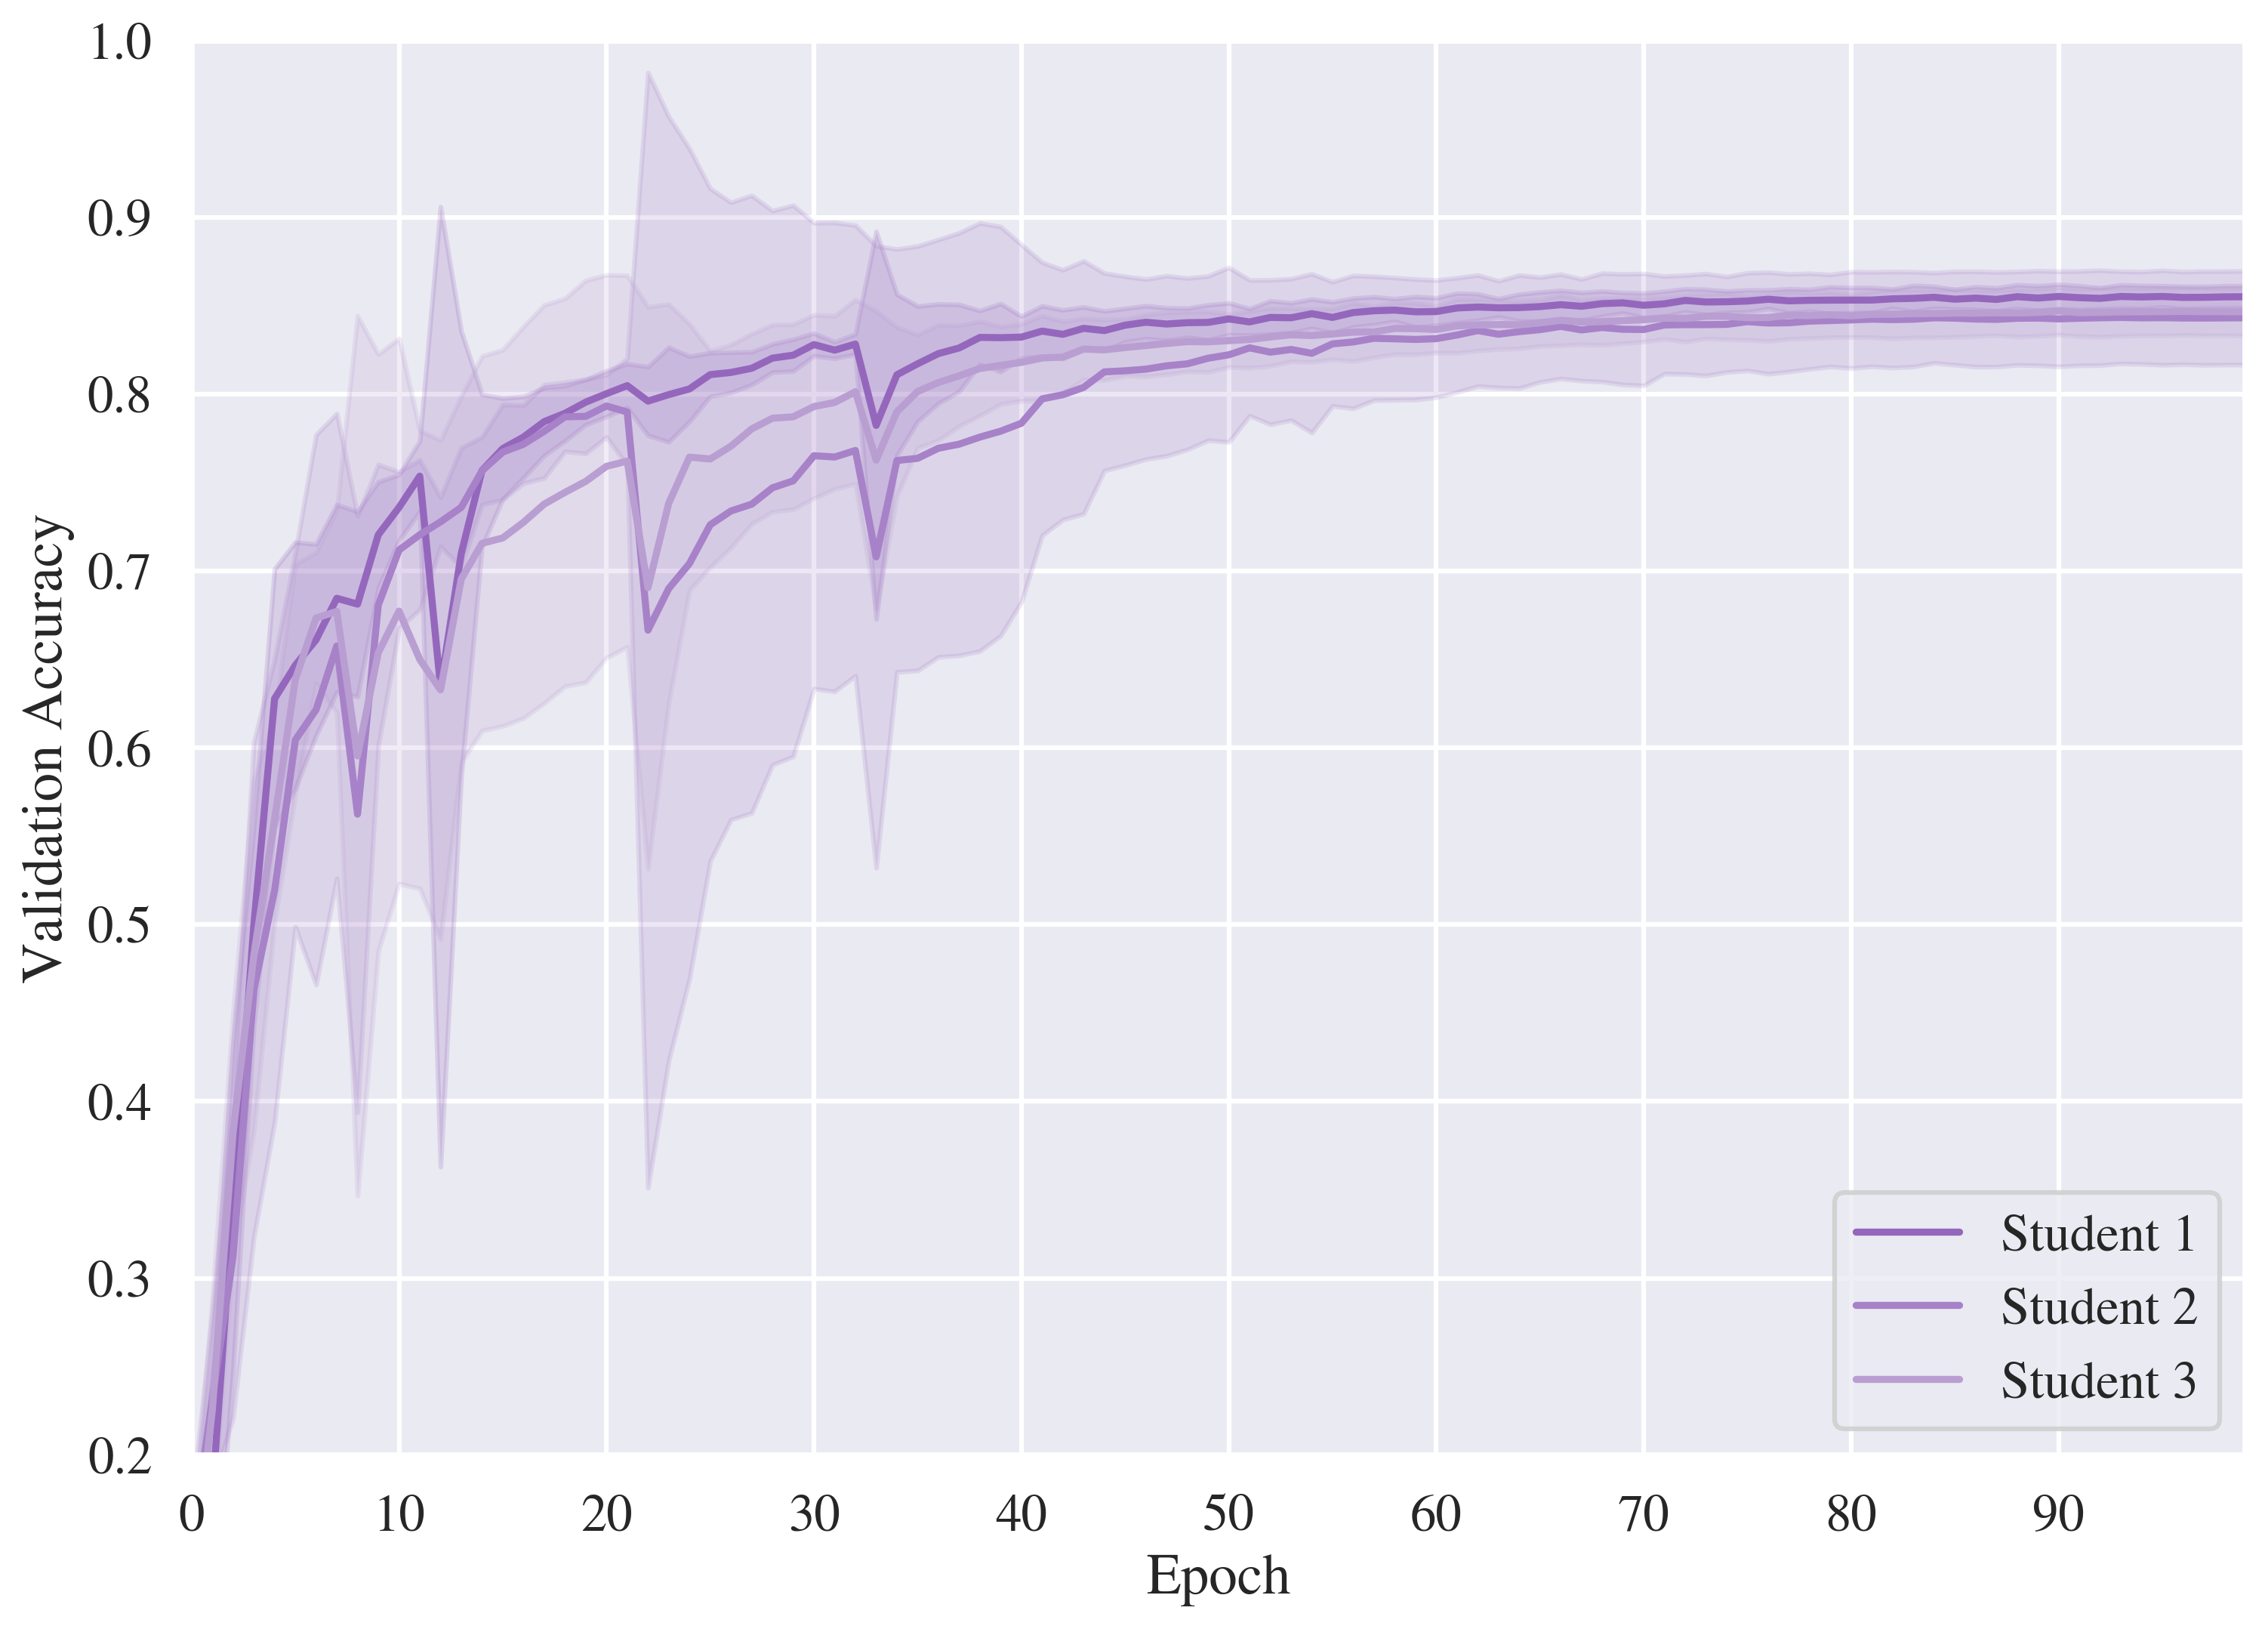

In [15]:
with sns.plotting_context("talk"):
    with sns.color_palette(dml_palette):
        ax = plot_df_no_color(dml_df, keep_dml, labels_dml)
        ax.set(xlabel='Epoch', ylabel='Validation Accuracy')
        ax.set_ylim(0.45, 1)
        ax.set_xlim(1, 100)
        # bbox_to_anchor=[1.2,1.0]
        ax.legend(title='Student Cohort', loc='lower right')

        ax.set_ylim(0.2, 1)
        ax.set_xlim(0, 99)
        ax.set_xticks([i for i in range(0, 100, 10)])
        # ax.legend(bbox_to_anchor=(0., 1.02, 1., 0.102), loc='lower left', ncol=5, mode='expand', borderaxespad=0.)
        # ax.get_legend().remove()
        ax.legend(title='', loc='lower right')

img_name = "dml-cohort_" + session_name
plt.savefig(f"/home/pia/Pictures/Plots/Thesis/{img_name}.pdf", bbox_inches="tight")
plt.savefig(f"/home/pia/Pictures/Plots/Thesis/{img_name}.png", bbox_inches="tight")

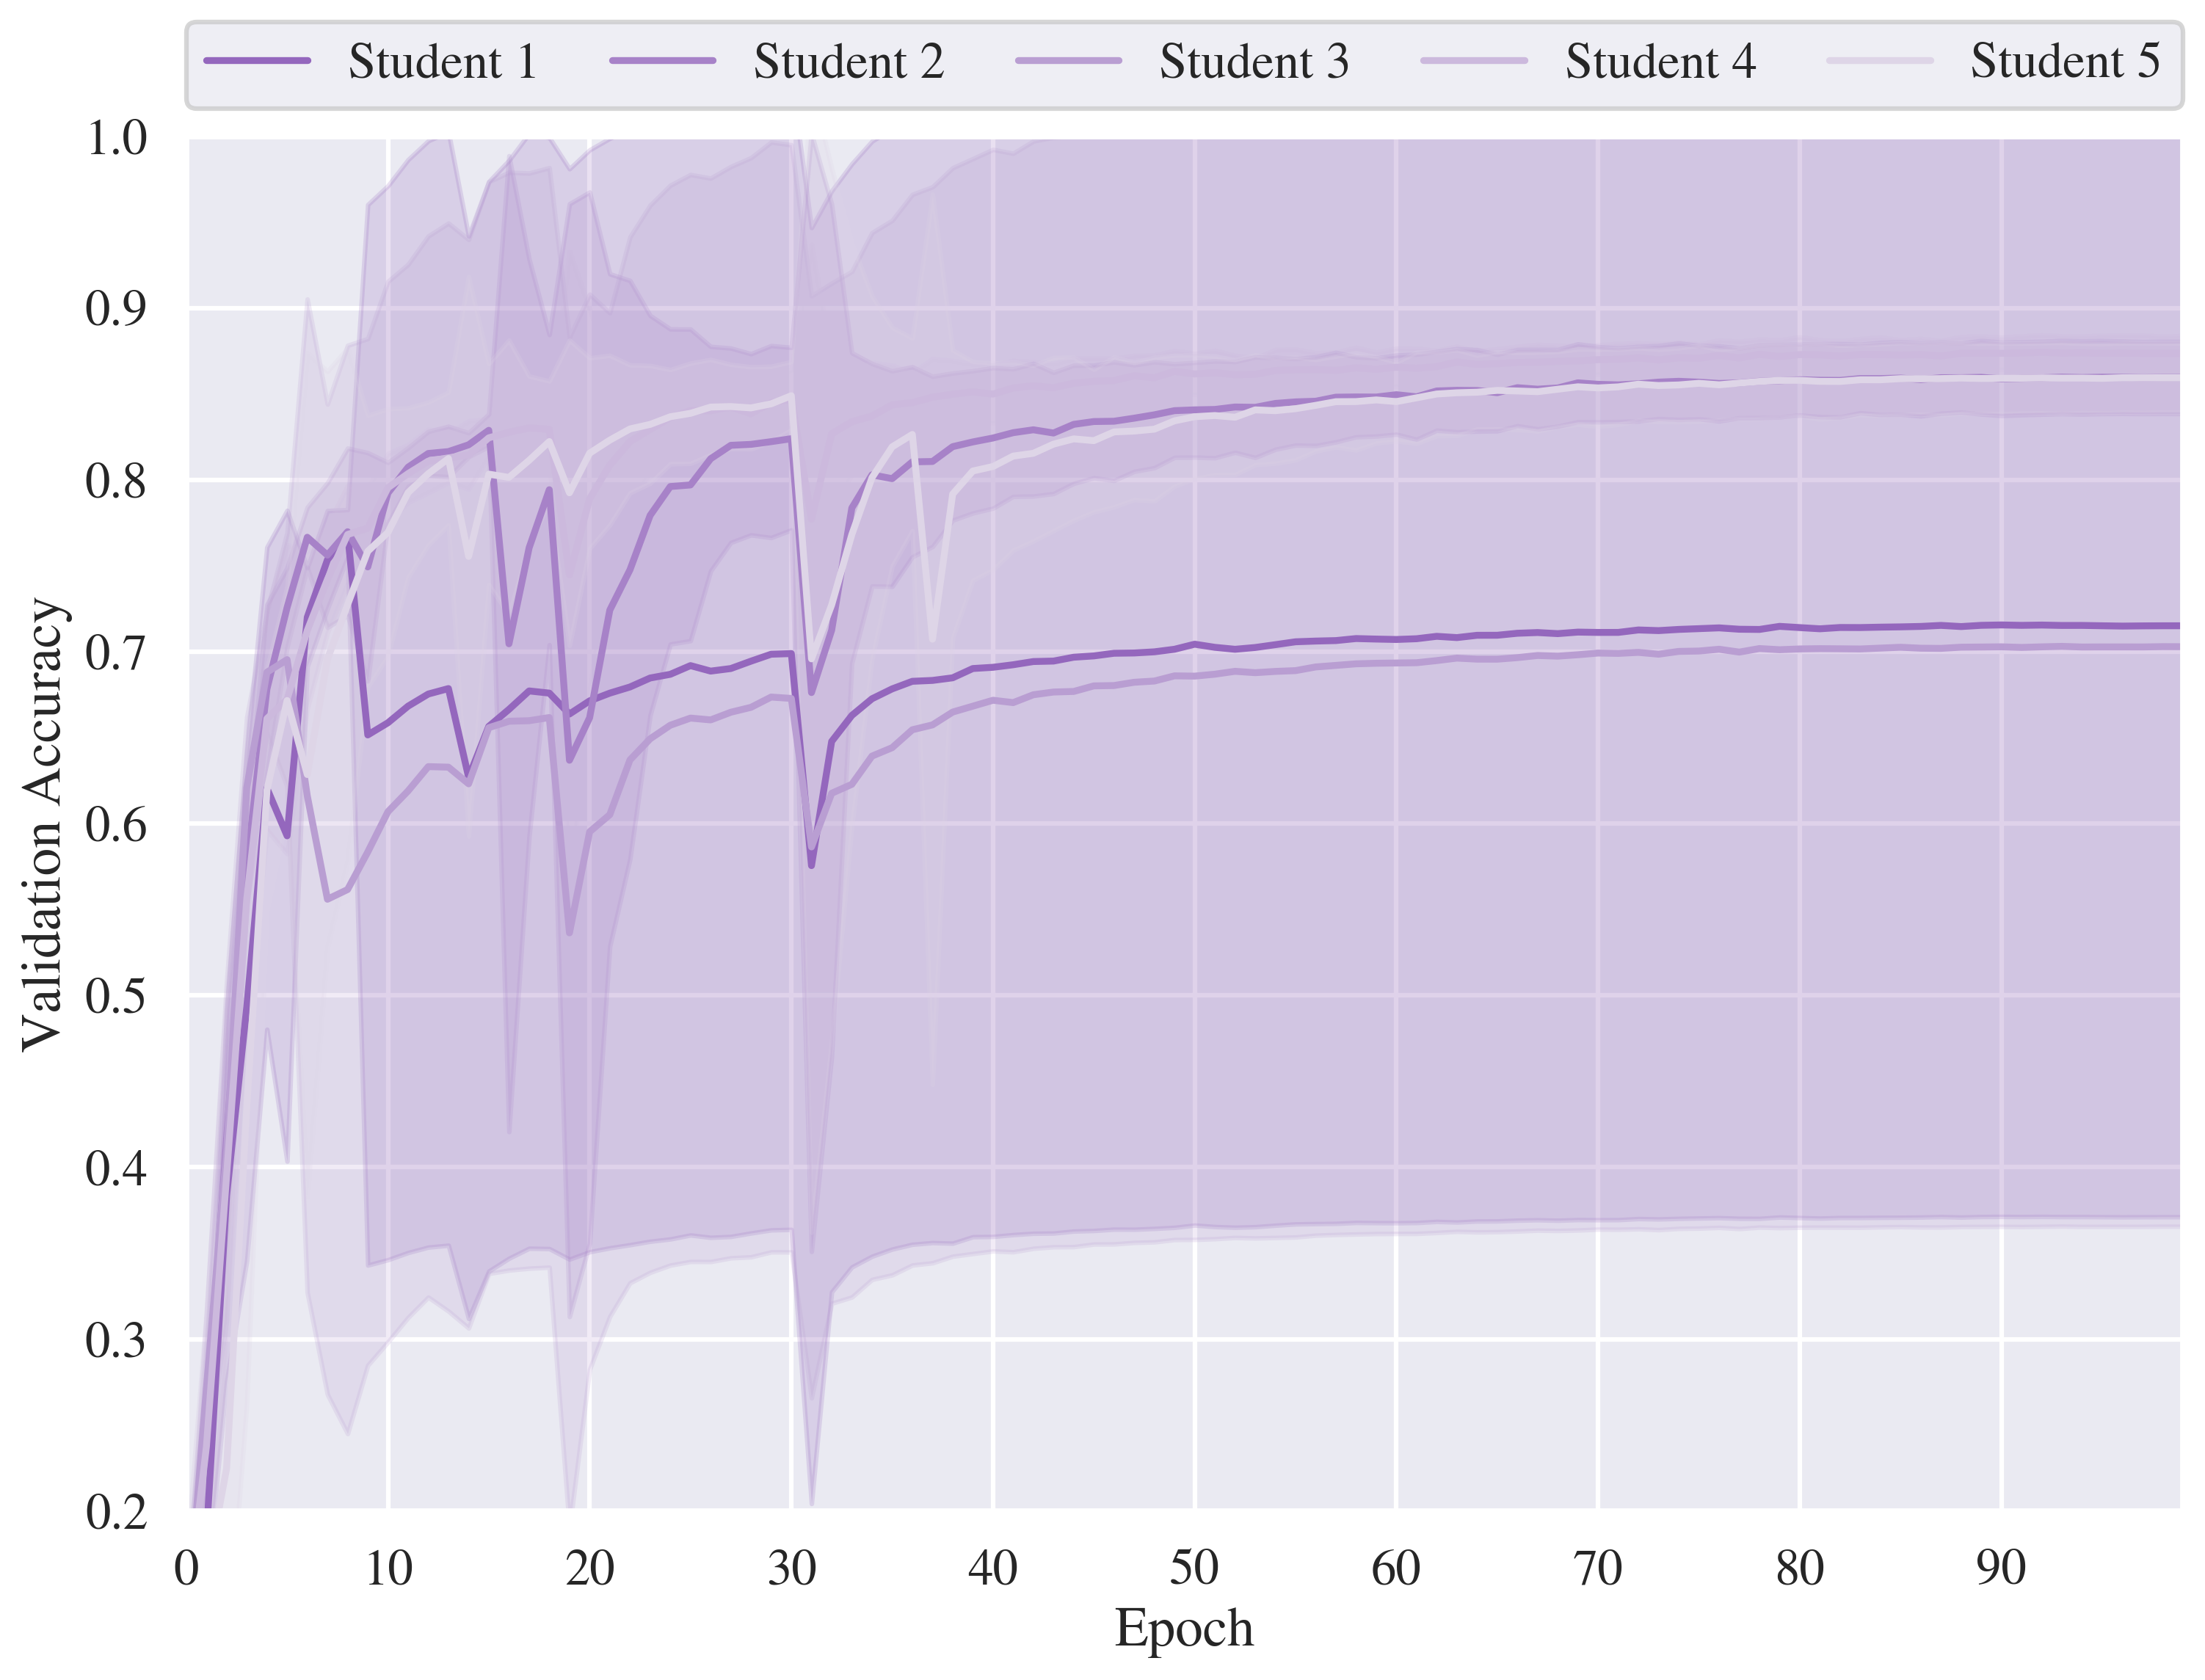

In [ ]:
with sns.plotting_context("talk"):
    with sns.color_palette(dml_palette):
        ax = plot_df_no_color(dml_df, keep_dml, labels_dml)
        ax.set(xlabel='Epoch', ylabel='Validation Accuracy')
        ax.set_ylim(0.45, 1)
        ax.set_xlim(1, 100)
        # bbox_to_anchor=[1.2,1.0]
        ax.legend(title='Student Cohort', loc='lower right')

        ax.set_ylim(0.2, 1)
        ax.set_xlim(0, 99)
        ax.set_xticks([i for i in range(0, 100, 10)])
        ax.legend(bbox_to_anchor=(0., 1.02, 1., 0.102), loc='lower left', ncol=5, mode='expand', borderaxespad=0.)
        # ax.get_legend().remove()

img_name = "dml-cohort_" + session_name
plt.savefig(f"/home/pia/Pictures/Plots/Thesis/{img_name}.pdf", bbox_inches="tight")
plt.savefig(f"/home/pia/Pictures/Plots/Thesis/{img_name}.png", bbox_inches="tight")

## Oversampling

In [16]:
df = pd.read_csv("~/Documents/Thesis/Data/oversampling_results.csv", delimiter=",")
small_df = df.mask(df["algo"] == "kd_50").dropna()

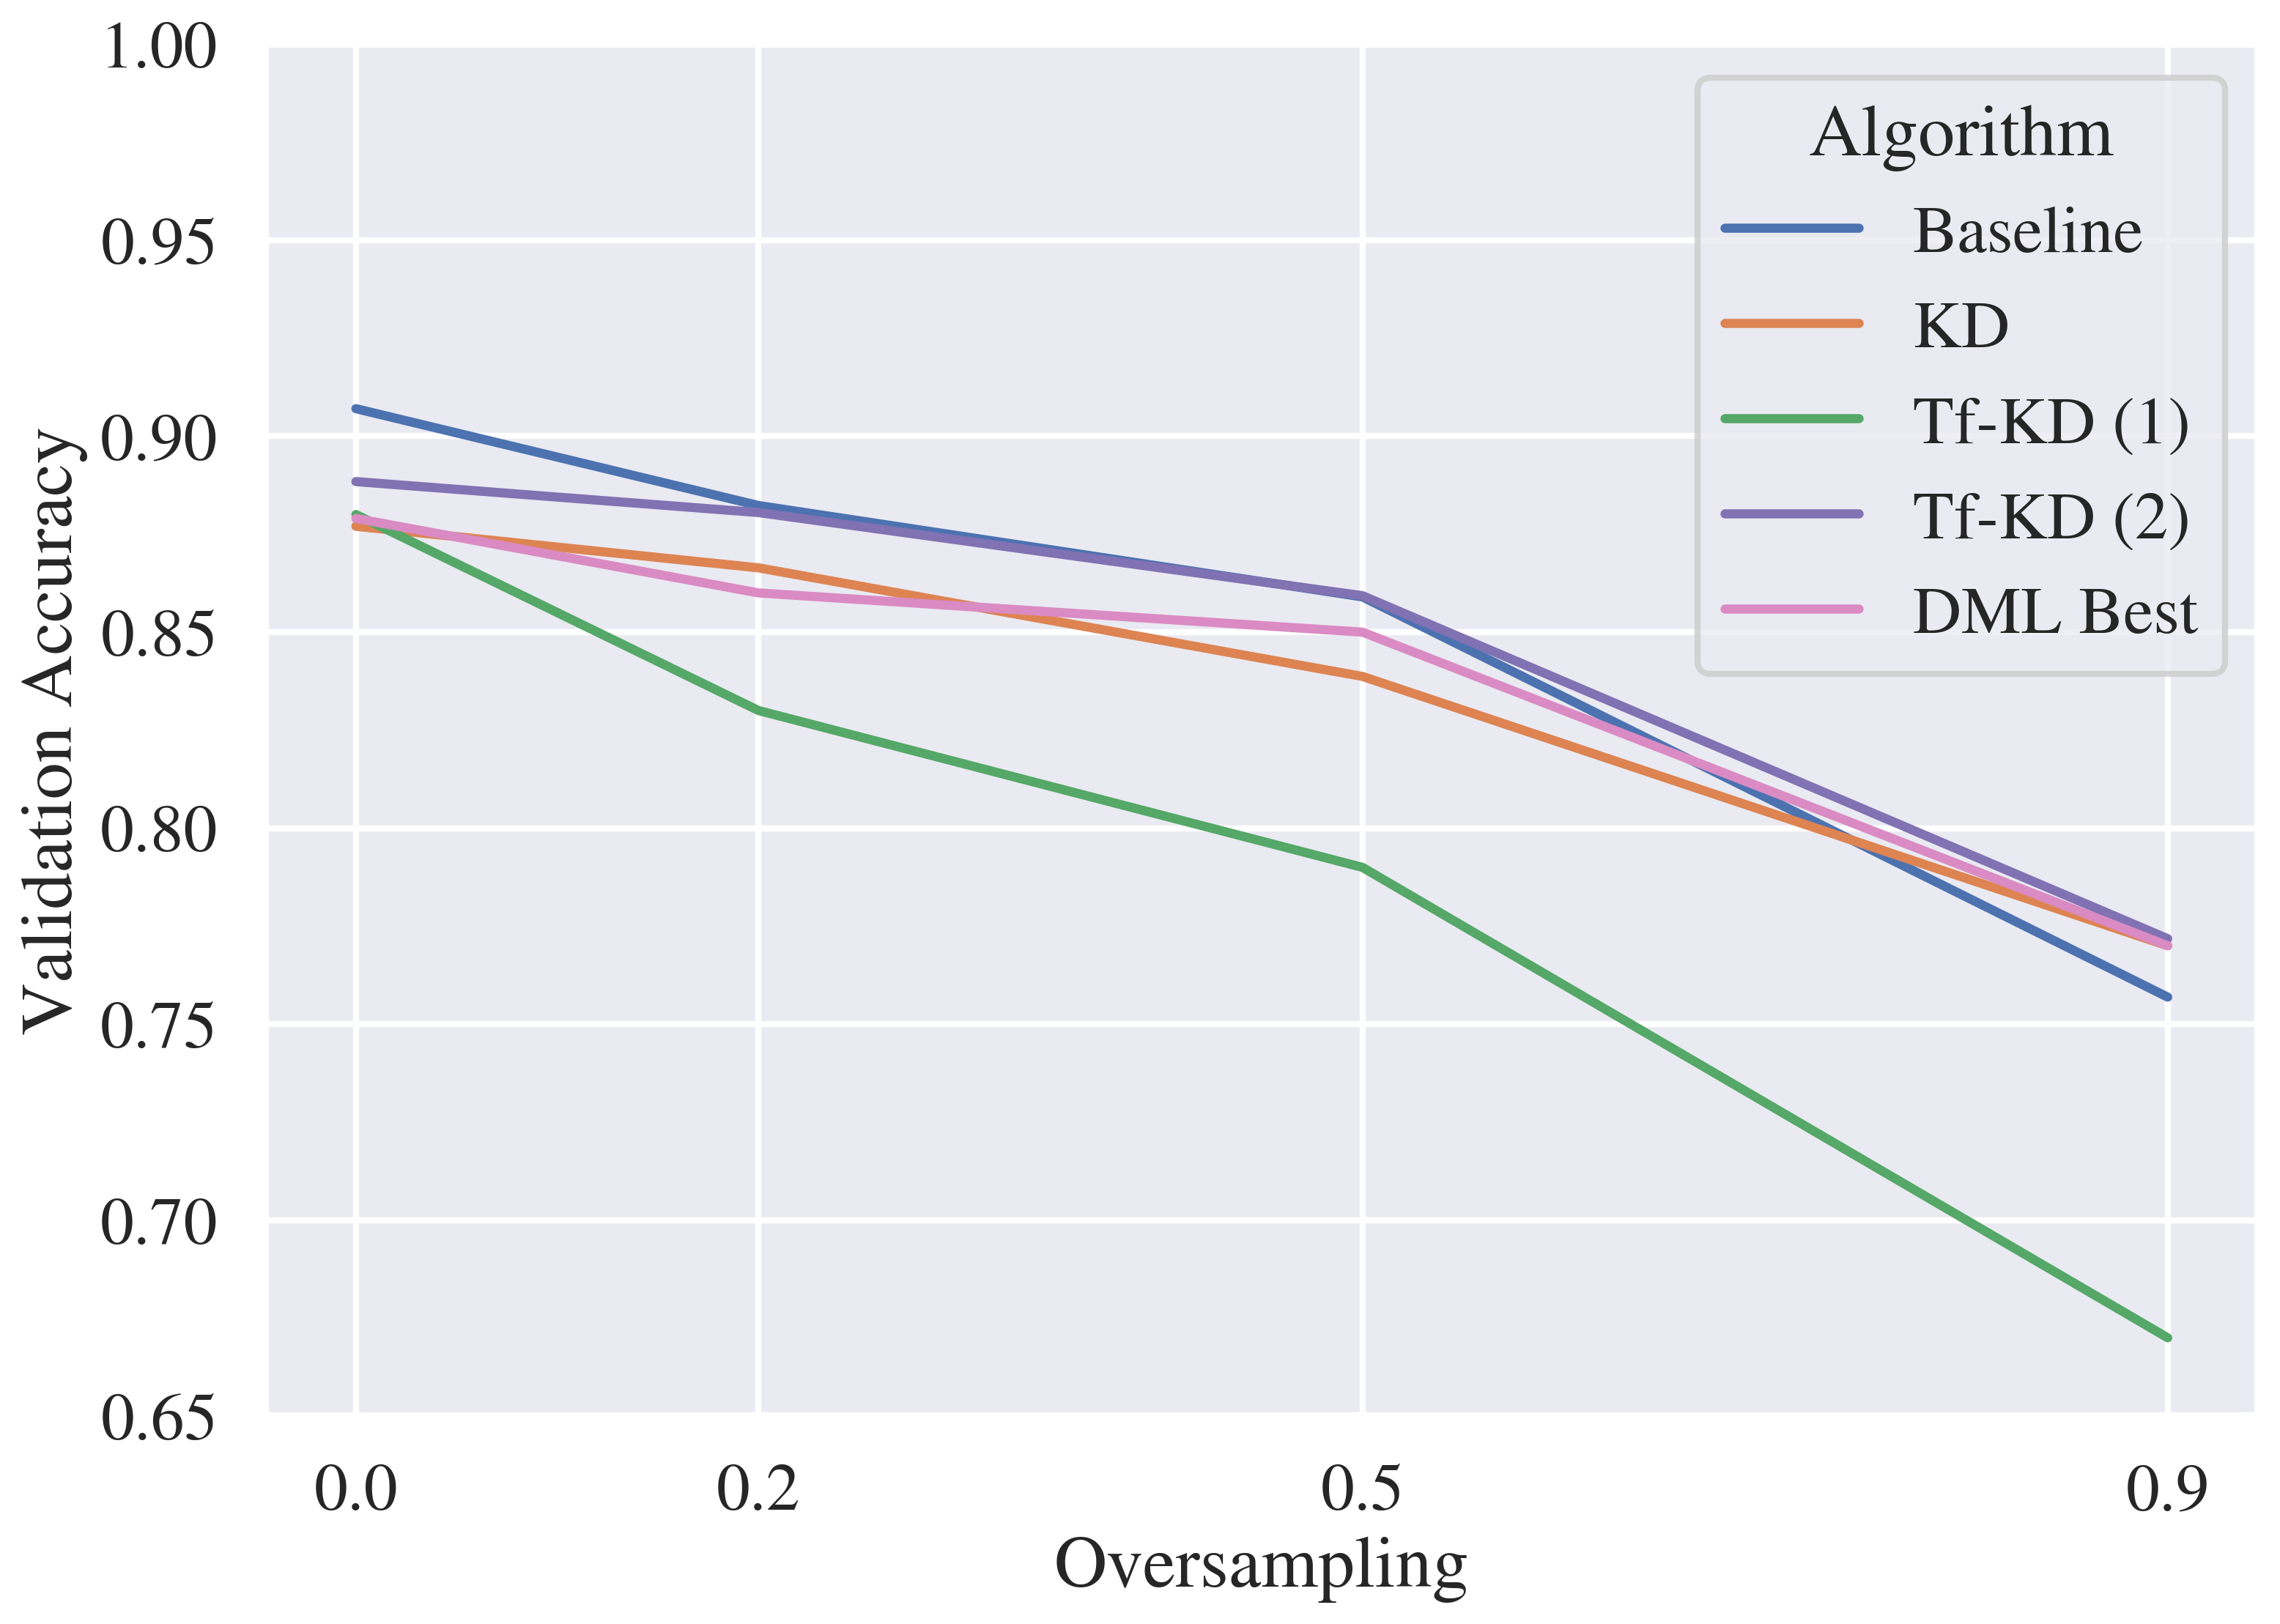

In [23]:
y_key = "unbiased_acc"

ax = sns.lineplot(data=small_df, x="sampling_factor", y=y_key, hue="algo", palette=palette[:5])
# ax.set_xlim(0.0, 0.9)
ax.set_xticks([0.0, 0.2, 0.5, 0.9])
ax.set_ylim(0.65, 1.0)
ax.legend(["Baseline", "KD", "Tf-KD (1)", "Tf-KD (2)", "DML Best"], title='Algorithm', loc='upper right')
ax.set(xlabel='Oversampling', ylabel='Validation Accuracy')

plt.savefig(f"/home/pia/Pictures/Plots/Thesis/oversampling_{y_key}.pdf", bbox_inches="tight")
plt.savefig(f"/home/pia/Pictures/Plots/Thesis/oversampling_{y_key}.png", bbox_inches="tight")

# Hyperparameters

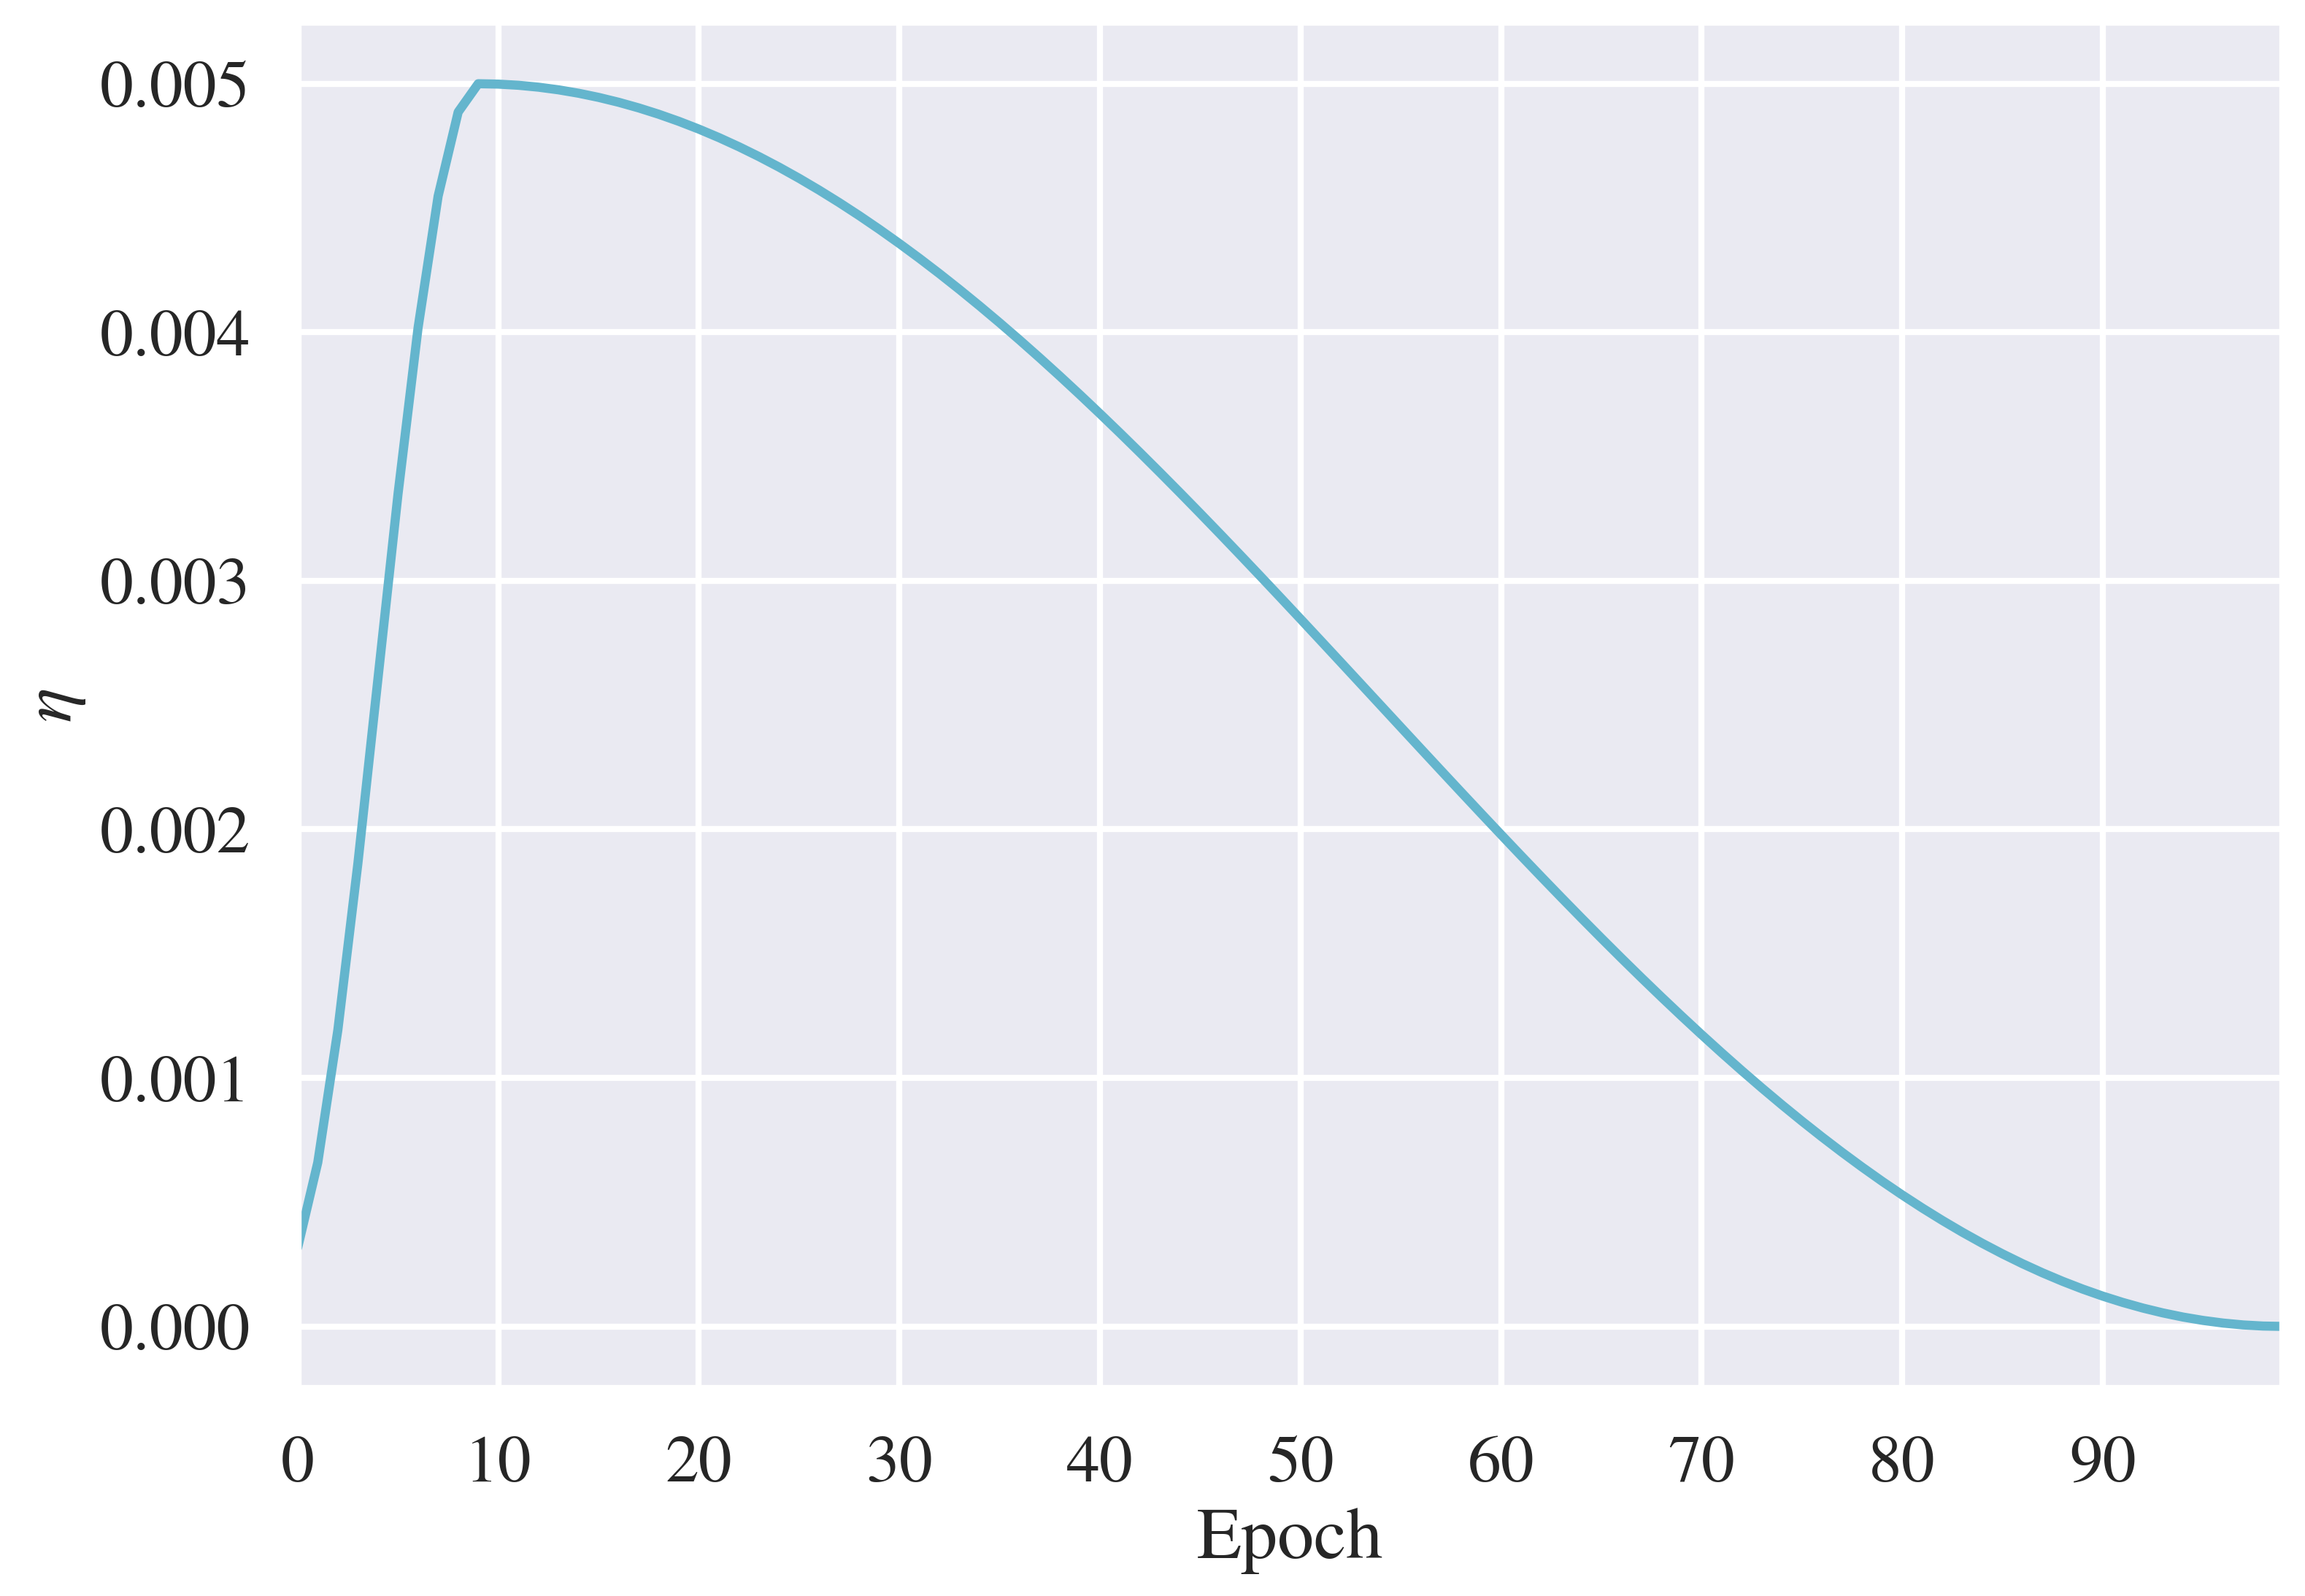

In [78]:
ax = plot_df(benchmark2[0], ["Optimizer/lr student"], [""], color=palette[-1])
ax.set(xlabel='Epoch', ylabel=r'$\eta$')
ax.set_xlim(0, 99)
ax.set_xticks([i for i in range(0, 100, 10)])

plt.savefig("/home/pia/Pictures/Plots/Thesis/learning_rate.pdf", bbox_inches="tight")
plt.savefig("/home/pia/Pictures/Plots/Thesis/learning_rate.png", bbox_inches="tight")

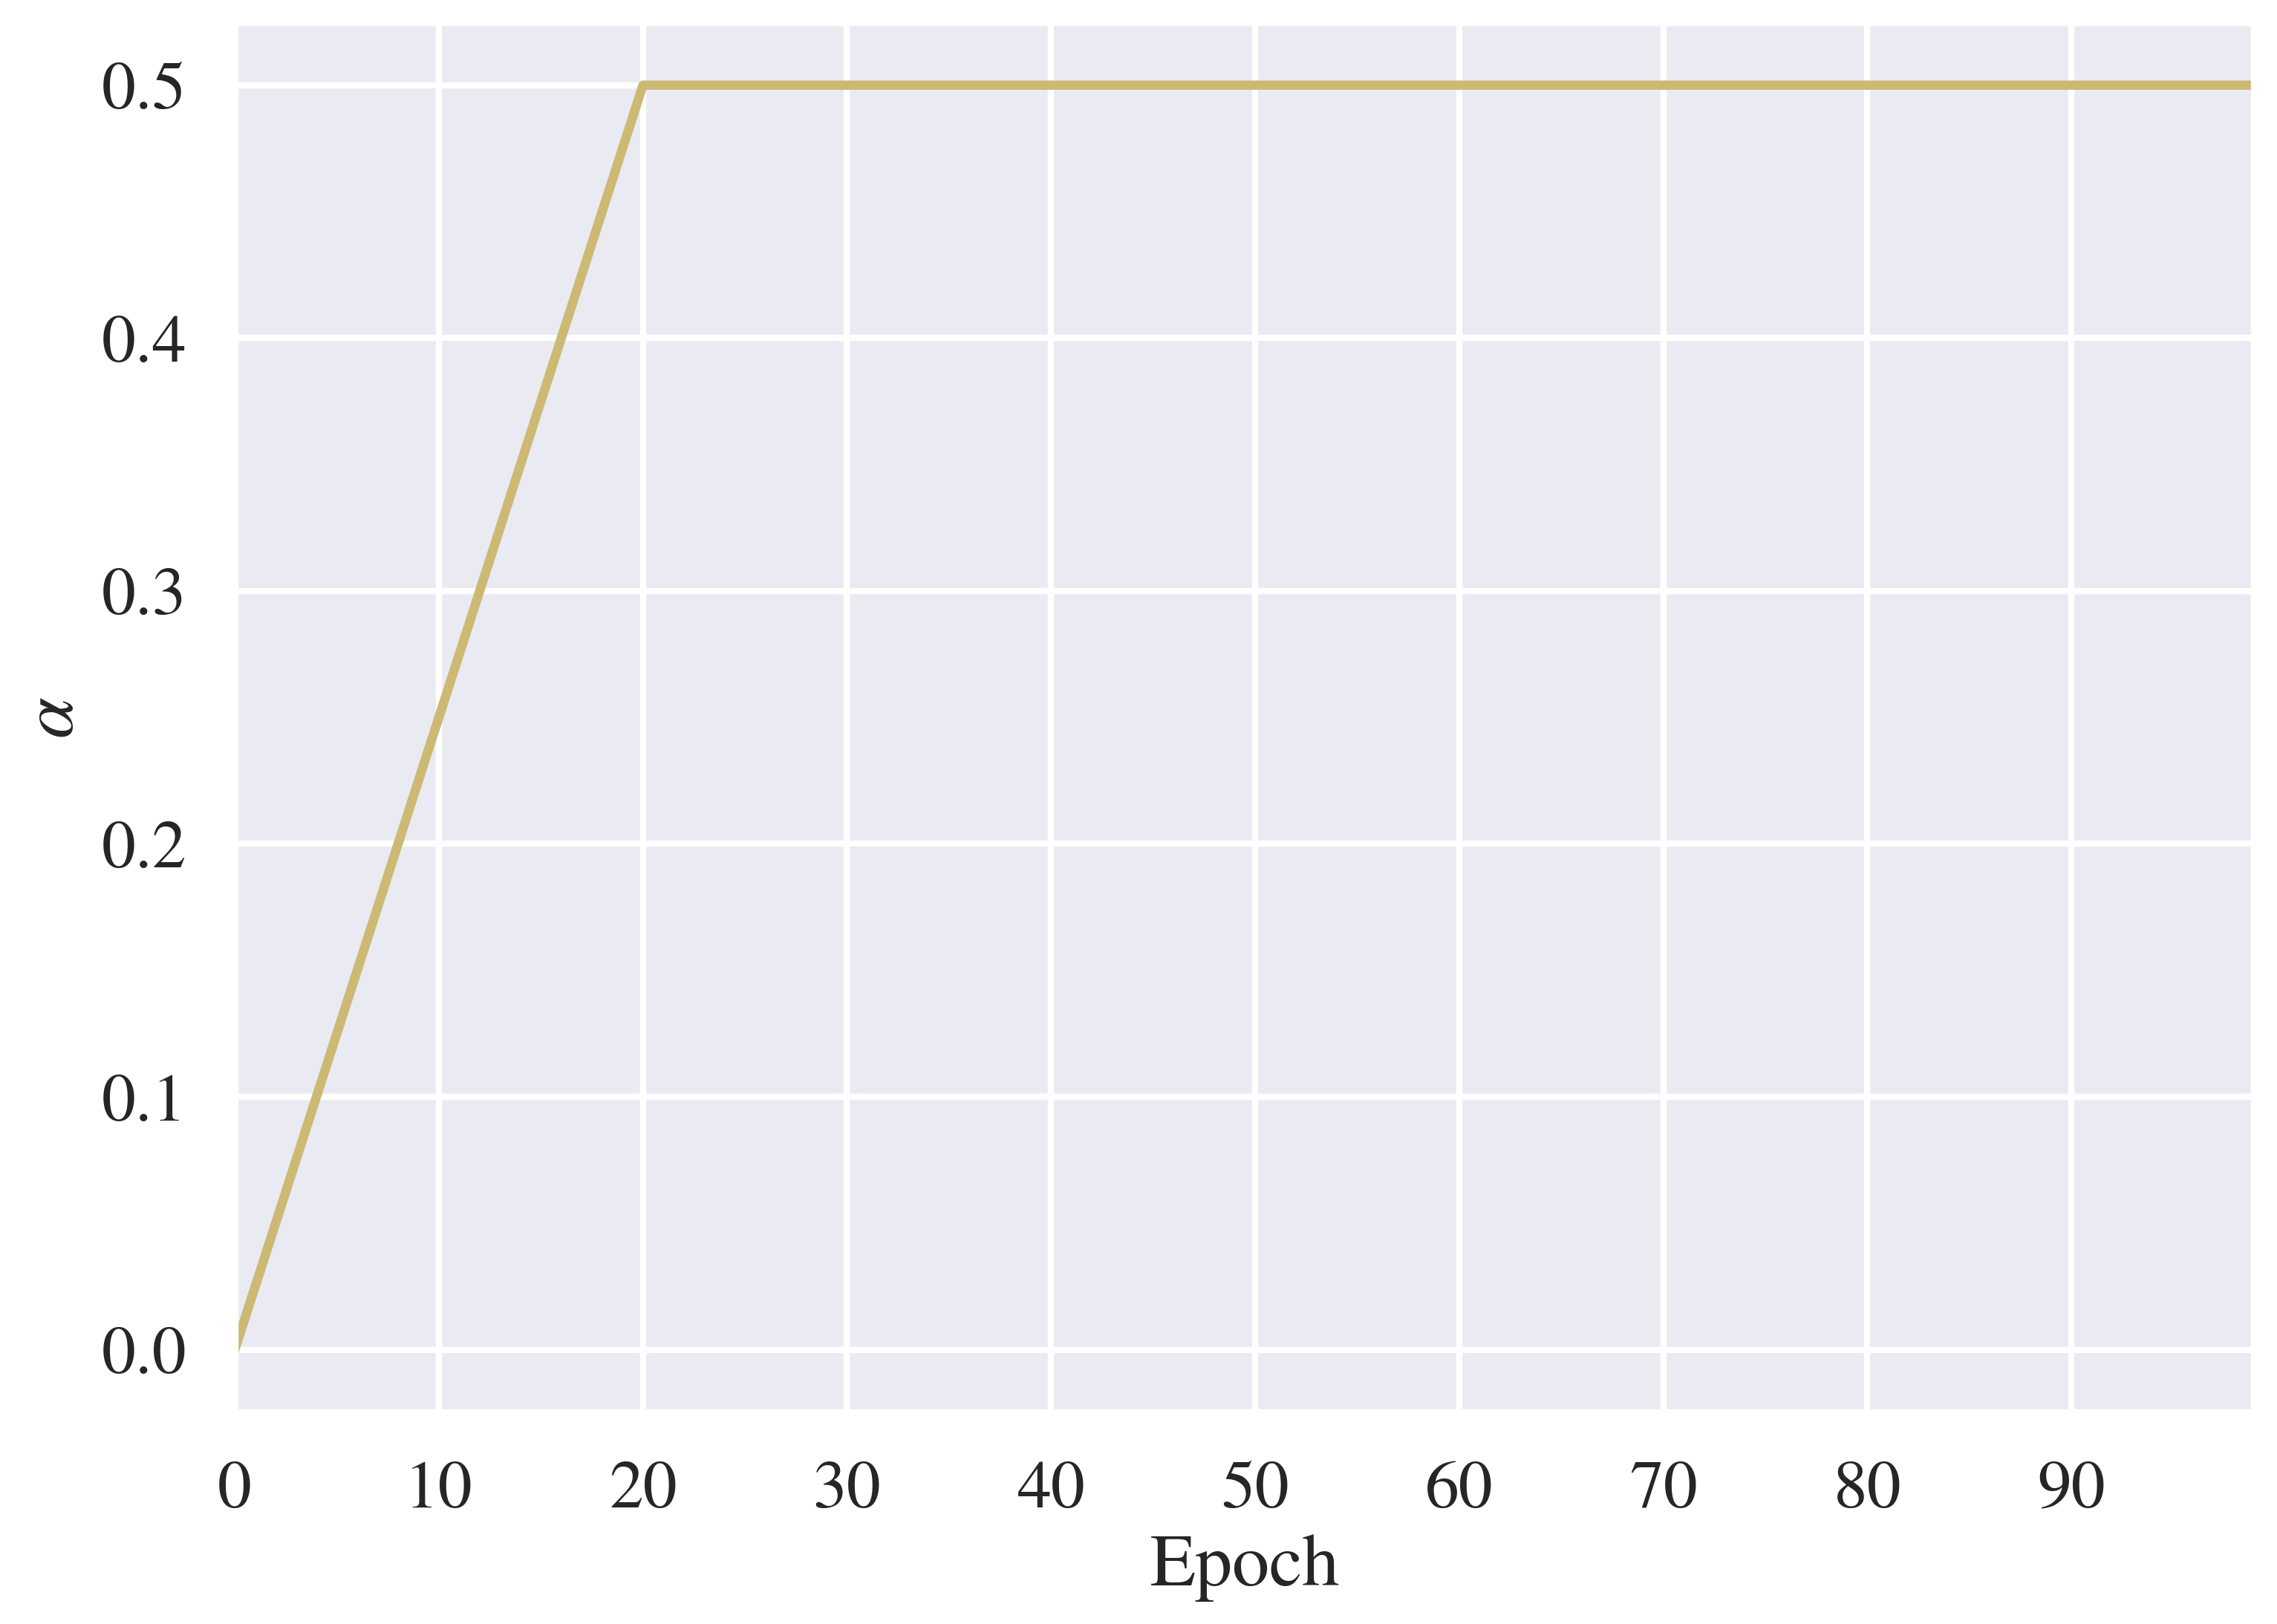

In [79]:
dml_hyperparam_df = pd.read_csv("../Experiments/hyperparams/adamw-001-10-True/dml.csv")
dml_hyperparam_df = preprocess_df(dml_hyperparam_df)

ax = plot_df(dml_hyperparam_df, ["Optimizer/Distillation weight"], [""], color=palette[-2])
ax.set(xlabel='Epoch', ylabel=r'$\alpha$')
ax.set_xlim(0, 99)
ax.set_xticks([i for i in range(0, 100, 10)])

plt.savefig("/home/pia/Pictures/Plots/Thesis/distil_weight.pdf", bbox_inches="tight")
plt.savefig("/home/pia/Pictures/Plots/Thesis/distil_weight.png", bbox_inches="tight")